# Preliminary

**The Objectives**

1. Explore data and do cleaning
2. Analysis the trend and pattern from data (time series)
3. Create Forecasting Models and Evaluate them

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')

import os

# mount drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [ ]:
# define folder
folder_path = '/content/drive/MyDrive/Dibimbing_DS/assignment/time_series/dataset/'

# find all_csv file with os.listdir
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# check the result
csv_files

['sales_data_april_2019.csv',
 'sales_data_august_2019.csv',
 'sales_data_december_2019.csv',
 'sales_data_february_2019.csv',
 'sales_data_january_2019.csv',
 'sales_data_july_2019.csv',
 'sales_data_june_2019.csv',
 'sales_data_march_2019.csv',
 'sales_data_may_2019.csv',
 'sales_data_november_2019.csv',
 'sales_data_october_2019.csv',
 'sales_data_september_2019.csv']

In [ ]:
# create list to store dataframe
dfs_data_sales = []

# read csv
for f in csv_files:
  file_path = os.path.join(folder_path, f)
  df = pd.read_csv(file_path,
                   na_values=['?'])

  # append to list
  dfs_data_sales.append(df)

# concat all dataframes (dfs)
data_sales = pd.concat(dfs_data_sales, ignore_index=True)

# print 5 row
data_sales.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [ ]:
# check dtypes
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


Hasil di atas menunjukkan bahwa:
1. Terdapat missing values yang kurang lebih jumlah sekitar 500 baris. Jika dilihat dari baris yang hilang besar kemungkinan meamng datanya kosong karena tidak ada order disitu
2. Terdapat kolom yang memiliki tipe data tidak sesuai dengan informasi yang seharusmya, seperti `Quantity Ordered`, `Price Each`, dan `Order Date`. Hal ini besar kemungkinan disebabkan oleh adanya nilai yang hilang sehingga pandas membaca fitur sebagai object

# Data preparation

## Handling Missing Value

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [ ]:
# check row
data_sales[data_sales.isnull().any(axis=1)].head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN


Jika dilihat dari jumlah baris, semua fitur memiliki jumlah yang sama. Hasil di atas menunjukkan bukti kuat bahwa semua fitur NaN adalah baris yang kosong untuk seluruh fitur. Sebelum menentukan metode yang akan dilakukan, kita akan melihat persentase berapa nilai yang hilang

In [ ]:
# the result in percentage
data_sales.isnull().sum() / len(data_sales) * 100

,0
Order ID,0.291678
Product,0.291678
Quantity Ordered,0.291678
Price Each,0.291678
Order Date,0.291678
Purchase Address,0.291678


Pesentase nilai missing tidak sampai 5% bahkan di bawah 1%. Maka dari itu, metode yang akan **saya lakukan adalah membunag baris yang hilang (*missing value*) tersebut**. Hal ini karena menghapus 545 baris dari 186.850 baris tidak akan berdampak signifikan pada dataset dalam kehilangan informasi.

Alasan mengapai tidak menggunakna `ffill` atau `bfill`, yang biasa digunakan dalam analisis time series (penting dalam deret waktu), karena nilai yang hilang ada di semua kolom/fitur. dua metode tersebut lebih cocok jika skenario di mana massing value hanya beberapa kolom dalam satu baris.

In [ ]:
# drop all row that contain missing value
data_sales.dropna(how='all', inplace=True)

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186305 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


In [ ]:
# sanity check
data_sales.isnull().sum() / len(data_sales) * 100

,0
Order ID,0.0
Product,0.0
Quantity Ordered,0.0
Price Each,0.0
Order Date,0.0
Purchase Address,0.0


## Check Invalid Value or Type in Data

Untuk memastikan kevalidan nilai dalam fitur atau menghindari adanya placeholder yang biasa digunakan untuk menandakan missing value, seperti Na, 99, -1, dsb, langkah selanjutnya adalah *looping* untuk semua fitur

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186305 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


In [ ]:
# loop the feature
for col in data_sales.columns.to_list():
  print(f'\n---------{col}----------')
  display(data_sales[col].value_counts())


---------Order ID----------


,count
Order ID,
Order ID,355
160873,5
295681,4
178158,4
226625,4
...,...
158177,1
158178,1
158179,1



---------Product----------


,count
Product,
USB-C Charging Cable,21903
Lightning Charging Cable,21658
AAA Batteries (4-pack),20641
AA Batteries (4-pack),20577
Wired Headphones,18882
Apple Airpods Headphones,15549
Bose SoundSport Headphones,13325
27in FHD Monitor,7507
iPhone,6842



---------Quantity Ordered----------


,count
Quantity Ordered,
1,168552
2,13324
3,2920
4,806
Quantity Ordered,355
5,236
6,80
7,24
8,5



---------Price Each----------


,count
Price Each,
11.95,21903
14.95,21658
2.99,20641
3.84,20577
11.99,18882
150,15450
99.99,13325
149.99,7507
700,6804



---------Order Date----------


,count
Order Date,
Order Date,355
12/15/19 20:16,8
12/11/19 13:24,7
04/02/19 13:24,7
10/30/19 21:28,7
...,...
09/05/19 19:00,1
09/18/19 10:13,1
09/15/19 23:01,1



---------Purchase Address----------


,count
Purchase Address,
Purchase Address,355
"193 Forest St, San Francisco, CA 94016",9
"223 Elm St, Los Angeles, CA 90001",8
"279 Sunset St, San Francisco, CA 94016",8
"662 Chestnut St, San Francisco, CA 94016",7
...,...
"210 Center St, Boston, MA 02215",1
"388 Jefferson St, San Francisco, CA 94016",1
"209 13th St, Dallas, TX 75001",1


* Terdapat pola dari jumlah yang sama, yakni 355 di semua fitur.
* Jika dilihat dengan seksama dalam baris di data, terdapat baris yang mengandung informasi nama kolom (header dari kolom).
* Besar kemungkinan ini adalah nilai yang hilang atau tidak valid
* Maka dari itu, kita perlu menghilangkan baris-baris yang mengandung nama kolom tersebut

In [ ]:
# create filter for row that contain header
is_header_row = (data_sales['Order ID'] == 'Order ID') | \
                (data_sales['Product'] == 'Product') | \
                (data_sales['Quantity Ordered'] == 'Quantity Ordered') | \
                (data_sales['Price Each'] == 'Price Each') | \
                (data_sales['Order Date'] == 'Order Date') | \
                (data_sales['Purchase Address'] == 'Purchase Address')

# exclude if is it
data_sales = data_sales[~is_header_row]

In [ ]:
# sanity check
# loop the feature
for col in data_sales.columns.to_list():
  print(f'\n---------{col}----------')
  display(data_sales[col].value_counts())


---------Order ID----------


,count
Order ID,
160873,5
226625,4
212334,4
277875,4
178158,4
...,...
259347,1
259346,1
259345,1



---------Product----------


,count
Product,
USB-C Charging Cable,21903
Lightning Charging Cable,21658
AAA Batteries (4-pack),20641
AA Batteries (4-pack),20577
Wired Headphones,18882
Apple Airpods Headphones,15549
Bose SoundSport Headphones,13325
27in FHD Monitor,7507
iPhone,6842



---------Quantity Ordered----------


,count
Quantity Ordered,
1,168552
2,13324
3,2920
4,806
5,236
6,80
7,24
8,5
9,3



---------Price Each----------


,count
Price Each,
11.95,21903
14.95,21658
2.99,20641
3.84,20577
11.99,18882
150,15450
99.99,13325
149.99,7507
700,6804



---------Order Date----------


,count
Order Date,
12/15/19 20:16,8
12/11/19 13:24,7
10/30/19 21:28,7
04/02/19 13:24,7
04/08/19 13:26,6
...,...
09/25/19 22:01,1
09/05/19 19:00,1
09/18/19 10:13,1



---------Purchase Address----------


,count
Purchase Address,
"193 Forest St, San Francisco, CA 94016",9
"279 Sunset St, San Francisco, CA 94016",8
"223 Elm St, Los Angeles, CA 90001",8
"640 West St, San Francisco, CA 94016",7
"550 Cherry St, San Francisco, CA 94016",7
...,...
"210 Center St, Boston, MA 02215",1
"388 Jefferson St, San Francisco, CA 94016",1
"209 13th St, Dallas, TX 75001",1


In [ ]:
# change dypes
data_sales['Order Date'] = pd.to_datetime(data_sales['Order Date'], errors='coerce')
data_sales['Quantity Ordered'] = pd.to_numeric(data_sales['Quantity Ordered'], errors='coerce')
data_sales['Price Each'] = pd.to_numeric(data_sales['Price Each'], errors='coerce')

In [ ]:
# sanity check
data_sales.isnull().sum()

,0
Order ID,0
Product,0
Quantity Ordered,0
Price Each,0
Order Date,0
Purchase Address,0


In [ ]:
# sanity check
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.9+ MB


## Check Data Duplicates

In [ ]:
# if the result 1 then there is no duplicates
len(data_sales.drop_duplicates()) / len(data_sales)

0.9985802635116967

Terdapat data duplikat

In [ ]:
# check the row
data_sales[data_sales.duplicated(keep=False)].sort_values(by='Order ID', ascending=True)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
68422,142071,AA Batteries (4-pack),1,3.84,2019-01-17 23:02:00,"131 2nd St, Boston, MA 02215"
68421,142071,AA Batteries (4-pack),1,3.84,2019-01-17 23:02:00,"131 2nd St, Boston, MA 02215"
71673,145143,Lightning Charging Cable,1,14.95,2019-01-06 03:01:00,"182 Jefferson St, San Francisco, CA 94016"
71672,145143,Lightning Charging Cable,1,14.95,2019-01-06 03:01:00,"182 Jefferson St, San Francisco, CA 94016"
73358,146765,Google Phone,1,600.00,2019-01-21 11:23:00,"918 Highland St, New York City, NY 10001"
...,...,...,...,...,...,...
51634,315955,ThinkPad Laptop,1,999.99,2019-12-26 17:28:00,"588 Chestnut St, Seattle, WA 98101"
51860,316173,AAA Batteries (4-pack),1,2.99,2019-12-22 22:44:00,"907 Sunset St, Portland, OR 97035"
51861,316173,AAA Batteries (4-pack),1,2.99,2019-12-22 22:44:00,"907 Sunset St, Portland, OR 97035"
53746,317971,AA Batteries (4-pack),1,3.84,2019-12-17 18:39:00,"250 Chestnut St, San Francisco, CA 94016"


Hasil di atas memberikan wawasan bahwa memang ada data duplikat yang identik untuk semua fitur, bahkan dari segi waktunya juga sama persis

In [ ]:
# drop duplicates
data_sales.drop_duplicates(inplace=True)

In [ ]:
# sanity check
# if the result 1 then there is no duplicates
len(data_sales.drop_duplicates()) / len(data_sales)

1.0

In [ ]:
df_sales_cleaned = data_sales.copy().reset_index(drop=True)
df_sales_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"


In [ ]:
df_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185686 entries, 0 to 185685
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185686 non-null  object        
 1   Product           185686 non-null  object        
 2   Quantity Ordered  185686 non-null  int64         
 3   Price Each        185686 non-null  float64       
 4   Order Date        185686 non-null  datetime64[ns]
 5   Purchase Address  185686 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 8.5+ MB


# EDA

## Gambaran Umum (Statistik Deskriptif)

In [ ]:
df_sales_cleaned.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity Ordered,185686.0,1.124544,1.0,1.0,1.0,1.0,9.0,0.443069
Price Each,185686.0,184.519255,2.99,11.95,14.95,150.0,1700.0,332.843838
Order Date,185686,2019-07-18 21:32:06.298051840,2019-01-01 03:07:00,2019-04-16 20:55:15,2019-07-17 20:11:00,2019-10-26 08:00:00,2020-01-01 05:13:00,NaN


In [ ]:
df_sales_cleaned.describe(include='object').T

,count,unique,top,freq
Order ID,185686,178437,160873,5
Product,185686,19,USB-C Charging Cable,21859
Purchase Address,185686,140787,"193 Forest St, San Francisco, CA 94016",9


* Hrga untuk masih-masih produk sangat bervariassi, ini terlihat dari nilai std mencapai 332.84. Sementara itu, mean > median yang menandakan adanya skewness. Hal ini wajar karena beberapa harga produk akan lebih tinggi karena perbedaa kualitas, tipe produk, dan lain sebagainya
* Untuk Order Date paling awal yang tercatat dalam data ada 1 Januari 2019 dan paling akhirnya adalah 1 Januari 2020.
* Adapun, total record yang tercatat setelah dilakukan pembersihan mencapau 185.686 record
* Terdapat 18 variasi produk dan produk yang paling banyak terjual adalah USB-C Charging Cable dengan total unit yang terjual sebanyak 21.859

In [ ]:
record_in_2020 = len(df_sales_cleaned[df_sales_cleaned['Order Date'] >= pd.to_datetime('2020-01-01')])
record_in_2020

34

In [ ]:
df_sales_cleaned[df_sales_cleaned['Order Date'] >= pd.to_datetime('2020-01-01')]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
31760,297150,Lightning Charging Cable,1,14.95,2020-01-01 00:38:00,"427 Wilson St, Dallas, TX 75001"
32459,297817,iPhone,1,700.00,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001"
32460,297817,Lightning Charging Cable,2,14.95,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001"
32619,297969,Google Phone,1,600.00,2020-01-01 00:54:00,"542 2nd St, San Francisco, CA 94016"
33000,298344,Wired Headphones,4,11.99,2020-01-01 03:34:00,"731 7th St, New York City, NY 10001"
33737,299049,Apple Airpods Headphones,1,150.00,2020-01-01 01:17:00,"762 Johnson St, San Francisco, CA 94016"
33817,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,"754 Hickory St, New York City, NY 10001"
35111,300362,USB-C Charging Cable,1,11.95,2020-01-01 00:59:00,"581 River St, San Francisco, CA 94016"
35273,300519,Bose SoundSport Headphones,1,99.99,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001"
35274,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001"


Ada 34 transaksi yang tercatat sepanjang 2020. Ini juga terjadi di awal tahun dan bulan. Hal ini mungkin saja disebabkan oleh perbedaan zona waktu yang tercatat atau ter-record ke dalam database. Mungkin juga kareana tanggal 01-01 dianggap sebagai transaksi akhir tahun jika mengacu pada pencatatan akuntansi/ laporan keuangan.

Hanya saja saya tetap akan memfilternya karena jumlahnya juga sedikit dan agar tidak bias mengubah data transaksi yang tercatat. Alasan lain mengapa dihapus ini akan menyebabkan plot dalam waktu terlihat ada penurunan padahal transaksi di bulan atau tahun tersebut belum utuh. Jadi saya memilih untuk memfilter hanya tahun 2019

In [ ]:
total_rows_before_filter = len(df_sales_cleaned)

# filter only record in 2019
df_sales_cleaned = df_sales_cleaned[df_sales_cleaned['Order Date'] < '2020-01-01']

In [ ]:
if (record_in_2020 + len(df_sales_cleaned)) == total_rows_before_filter:
  print('The filter is correct')

The filter is correct


In [ ]:
# sanity check with stats descriptive
df_sales_cleaned.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity Ordered,185652.0,1.124529,1.0,1.0,1.0,1.0,9.0,0.443026
Price Each,185652.0,184.507245,2.99,11.95,14.95,150.0,1700.0,332.83495
Order Date,185652,2019-07-18 20:48:16.720315392,2019-01-01 03:07:00,2019-04-16 20:51:00,2019-07-17 19:49:30,2019-10-26 05:17:45,2019-12-31 23:53:00,NaN


In [ ]:
df_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185652 entries, 0 to 185685
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185652 non-null  object        
 1   Product           185652 non-null  object        
 2   Quantity Ordered  185652 non-null  int64         
 3   Price Each        185652 non-null  float64       
 4   Order Date        185652 non-null  datetime64[ns]
 5   Purchase Address  185652 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.9+ MB


sudah berhasil dan sesuai

## 1a: Total Revenue, Jumlah Order, dan Jumlah barang terjual sepanjang 2019.

In [ ]:
df_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185652 entries, 0 to 185685
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185652 non-null  object        
 1   Product           185652 non-null  object        
 2   Quantity Ordered  185652 non-null  int64         
 3   Price Each        185652 non-null  float64       
 4   Order Date        185652 non-null  datetime64[ns]
 5   Purchase Address  185652 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.9+ MB


In [ ]:
# Calculate Revenue
df_sales_cleaned['Revenue'] = df_sales_cleaned['Quantity Ordered'] * df_sales_cleaned['Price Each']

df_sales_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [ ]:
# sanity check
df_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185652 entries, 0 to 185685
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185652 non-null  object        
 1   Product           185652 non-null  object        
 2   Quantity Ordered  185652 non-null  int64         
 3   Price Each        185652 non-null  float64       
 4   Order Date        185652 non-null  datetime64[ns]
 5   Purchase Address  185652 non-null  object        
 6   Revenue           185652 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 11.3+ MB


In [ ]:
# check with unique
print(f"Total unique: {df_sales_cleaned['Order ID'].nunique()}")
print(f"Value Counts: {df_sales_cleaned['Order ID'].value_counts()}")

Total unique: 178406
Value Counts: Order ID
160873    5
165665    4
193511    4
296353    4
277875    4
         ..
158145    1
158146    1
158147    1
158148    1
158137    1
Name: count, Length: 178406, dtype: int64


* Total Unqiue = 178437 dan Total baris Total baris = 185686 yang mana ada 7513 baris yang memiliki Order ID yang sama dengan baris lain. Ini adalah baris-baris dari pesanan yang berisi beberapa jenis produk yang berbeda. Misalnya untuk menghithng total order dalam hari, perhitungan agregasi dengan nunique lebih menggambarkan total order per hari tersebut dibandingkan count.
* Ini juga menjadi catatan jika berhadapan dengan agregasi untuk masing-masing Order ID (transaksi) nanti, perhitungan per transaksi dengan `sum` lebih tepat.

In [ ]:
# check the order total is > 1
df_sales_cleaned[df_sales_cleaned['Order ID'] == '160873']

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue
65929,160873,iPhone,1,700.00,2019-02-10 10:24:00,"702 River St, San Francisco, CA 94016",700.00
65930,160873,Lightning Charging Cable,1,14.95,2019-02-10 10:24:00,"702 River St, San Francisco, CA 94016",14.95
65931,160873,Apple Airpods Headphones,1,150.00,2019-02-10 10:24:00,"702 River St, San Francisco, CA 94016",150.00
65932,160873,Wired Headphones,1,11.99,2019-02-10 10:24:00,"702 River St, San Francisco, CA 94016",11.99
65933,160873,Google Phone,1,600.00,2019-02-10 10:24:00,"702 River St, San Francisco, CA 94016",600.00


In [ ]:
# calculate sales in daily
sales_in_daily = df_sales_cleaned.set_index('Order Date').resample('D').agg(
    {
     'Revenue': 'sum',
     'Order ID': 'nunique',
     'Quantity Ordered': 'sum'
    }
)

sales_in_daily.head()

,Revenue,Order ID,Quantity Ordered
Order Date,,,
2019-01-01,65681.94,287,343
2019-01-02,70663.20,308,367
2019-01-03,47046.20,286,330
2019-01-04,62000.22,282,329
2019-01-05,46524.63,301,355


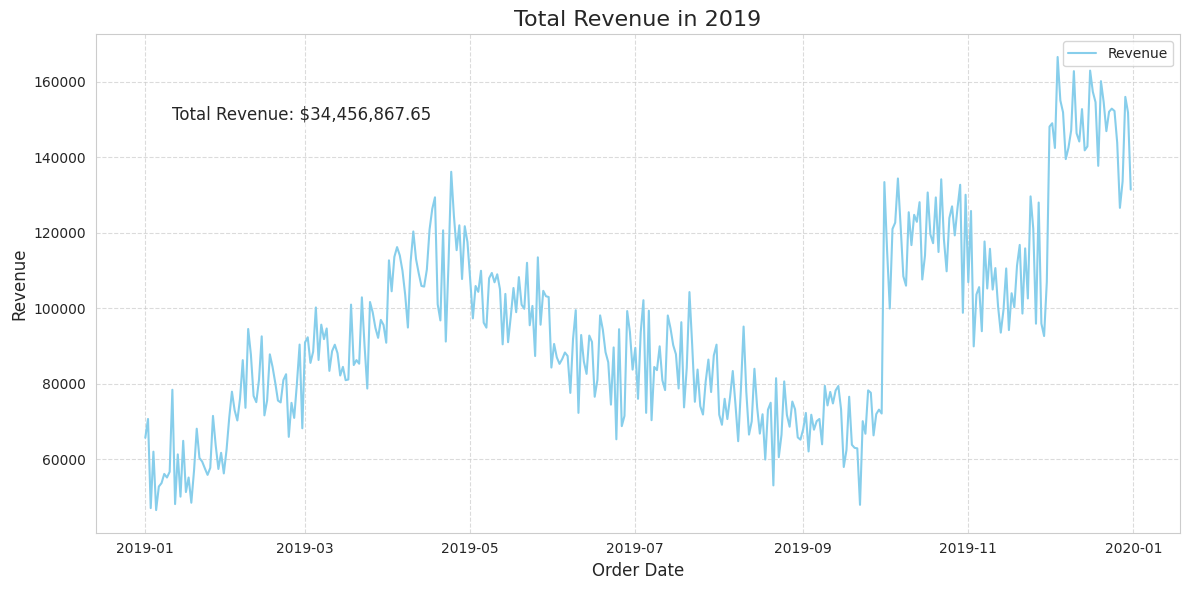

In [ ]:
# calcuate total revenue
total_revenue_2019 = sales_in_daily['Revenue'].sum()

# total revenue throughout 2019
plt.figure(figsize=(12, 6))
plt.plot(sales_in_daily.index, sales_in_daily['Revenue'], label='Revenue', color='skyblue')

plt.title('Total Revenue in 2019', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# add total revenue into figure
plt.text(sales_in_daily.index[10], sales_in_daily['Revenue'].max() * 0.9,
         f'Total Revenue: ${total_revenue_2019:,.2f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

* Total Revenue sepanjang 2019 mencapai 34 juta dolar
* Revenue sepanjang 2019 memiliki pola awal yang bisa diidentifikasi. Setidaknya sepanjang Januari (01) sampai April (04) terdapat pola naik. Kemudian dari bulan Mei (05) sampai sekitar September (09) terjadi penurunan. Terus kembali naik lagi di bulan berikut Oktober (10) sampai Desember (12).
* Pola ini menandakan adanya kemungkina pola musiman.
* Ada kenaikan drastisdi sekitar bulan September Oktober yang mana perlu menjadi catatan
* Puncak penjualan tahunan terlihat jelas dari Oktober hingga akhir Desember, dengan lonjakan drastis yang kemungkinan besar dipicu oleh holiday season seperti Black Friday dan Natal.

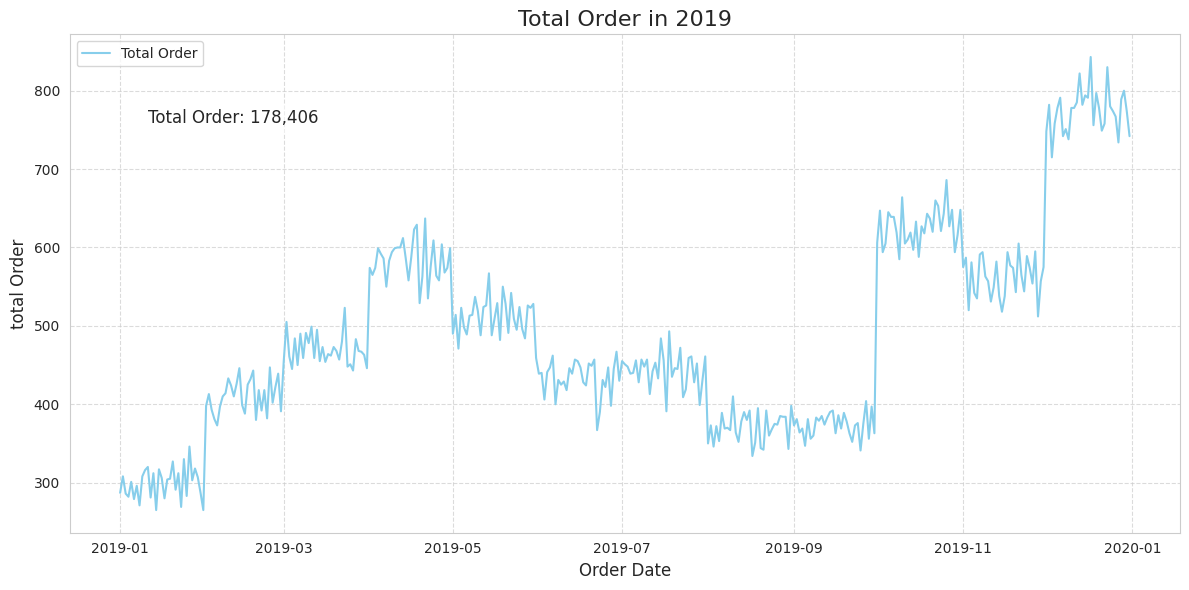

In [ ]:
# calcuate total order
total_order_2019 = sales_in_daily['Order ID'].sum()

# total order throughout 2019
plt.figure(figsize=(12, 6))
plt.plot(sales_in_daily.index, sales_in_daily['Order ID'], label='Total Order', color='skyblue')

plt.title('Total Order in 2019', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('total Order', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# add total ordder into figure
plt.text(sales_in_daily.index[10], sales_in_daily['Order ID'].max() * 0.9,
         f'Total Order: {total_order_2019:,.0f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

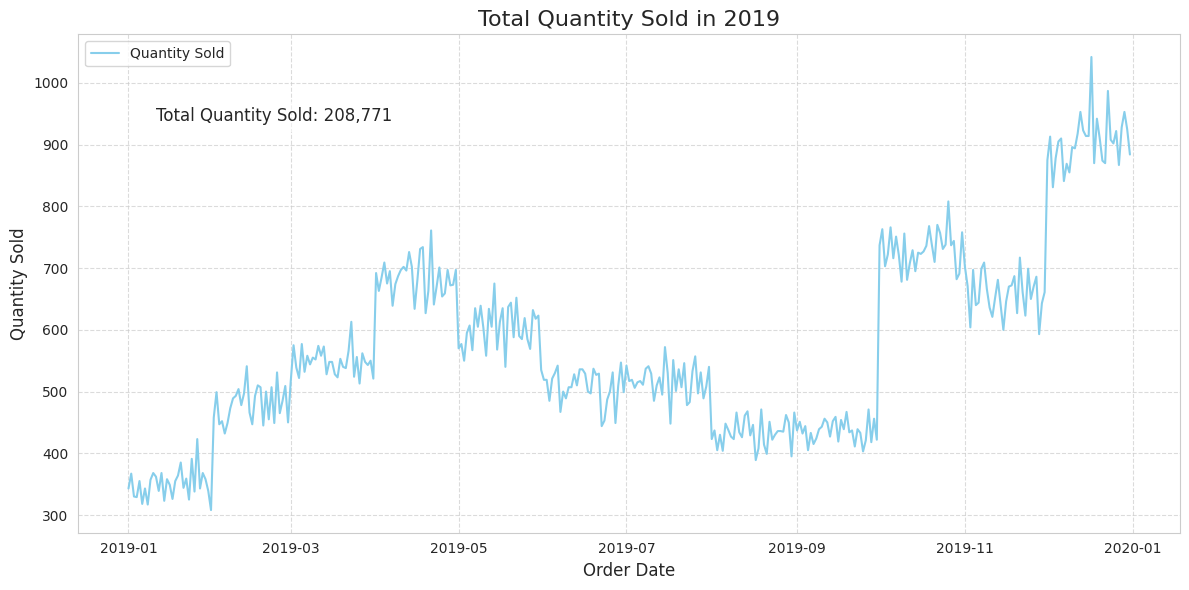

In [ ]:
# calcuate quantity sold
total_qs_2019 = sales_in_daily['Quantity Ordered'].sum()

# total quantity sold throughout 2019
plt.figure(figsize=(12, 6))
plt.plot(sales_in_daily.index, sales_in_daily['Quantity Ordered'], label='Quantity Sold', color='skyblue')

plt.title('Total Quantity Sold in 2019', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# add total ordder into figure
plt.text(sales_in_daily.index[10], sales_in_daily['Quantity Ordered'].max() * 0.9,
         f'Total Quantity Sold: {total_qs_2019:,.0f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

* Total Quantity yang terjual sepanjang 2019 mencapai ~208 ribu unit dan Order yang diterima/didapatkan sebanyak ~178 ribu order.
* Pola Total Order ataupun Total barang yang terjual tidak jauh berbeda dengan Total Revenue.
* Ini semakin menguatkan kemungkinan bahwa memang ada pola musiman yang mungkin kuat
* Hal ini juga menyiratkan bahwa volume transaksi (Total Order) dan jumlah unit produk yang terjual (Quantity Sold) adalah kemungkinan pendorong dari fluktuasi pendapatan, dan ketiganya bergerak sejalan

## 1b: Rata-rata jumlah barang yang dibeli per transaksi dan rata-rata spending pertransaksi.

In [ ]:
# stats descriptive
df_sales_cleaned.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity Ordered,185652.0,1.124529,1.0,1.0,1.0,1.0,9.0,0.443026
Price Each,185652.0,184.507245,2.99,11.95,14.95,150.0,1700.0,332.83495
Order Date,185652,2019-07-18 20:48:16.720315392,2019-01-01 03:07:00,2019-04-16 20:51:00,2019-07-17 19:49:30,2019-10-26 05:17:45,2019-12-31 23:53:00,NaN
Revenue,185652.0,185.599227,2.99,11.95,14.95,150.0,3400.0,333.023492


In [ ]:
# create summary order dan revenue
order_summary = df_sales_cleaned.groupby('Order ID').agg(
    total_quantity_per_order=('Quantity Ordered', 'sum'),
    total_revenue_per_order=('Revenue', 'sum')
)

# calculate the average
avg_quantity_per_order = order_summary['total_quantity_per_order'].mean()
avg_spending_per_order = order_summary['total_revenue_per_order'].mean()

print(f"Rata-rata jumlah barang per transaksi: {avg_quantity_per_order:.2f}")
print(f"Rata-rata spending per transaksi: ${avg_spending_per_order:.2f}")

Rata-rata jumlah barang per transaksi: 1.17
Rata-rata spending per transaksi: $193.14


* Hasil statistik deskriptif menunjukkan bahwa seecara keseluruhan rata-rata Revenue mencapai $184.52 dan Quantity Ordered adalah 1.12.
* Jika ditarik berdasarkan per transaksi, kita sudah mengetahui bahwa memang satu transaksi bisa membeli beragam produk. Maka dari itu, nilai rata-rata pengeluaran atau jumbla barang yang terjual per transaksi akan lebih besar dibandingkan rata-rata secara keseluruhan
* Bisa dikatakan per transaksi, konsumen menghabiskan 193.15 dolar dan barang yang dibeli/terjual sekitar 1 unit.
* Tentunya ini tidak menafikkan adanya outlier karena sangat mungkin satu transaksi bernilai sangat besar di sisi lain ada transaksi yang nominalnya kecil tergantung kemampuan atau kebutuhan konsumen.

## 2: Menghitung Total Order dan GMV

GMV adalah Gross Merchandise Value atau nilai pemblian dari pengguna/konsumen dalam konteks ini, bisa lewat app atau web dari e-commerce.

GMV dihitung dengan mengkalikan harga jual barang dengan jumlah barang yang terjualnya. Dalam konteks ini tidak ada biaya atau diskon yang dibayarkan oleh konsuumen sehinga untuk menghitungnya cukup mengalikan `Quantity Ordered` dengan `Price Each` atau bisa menggunakan kolom `Revenue` karena sebelumnya sudah dilakukna

In [ ]:
df_sales_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [ ]:
# create total order and GMV (total Revenue)
# in Month
sales_in_month = df_sales_cleaned.set_index('Order Date').resample('M').agg({
    'Revenue': 'sum',
    'Order ID': 'nunique'
})

# in Week
sales_in_week = df_sales_cleaned.set_index('Order Date').resample('W').agg({
    'Revenue': 'sum',
    'Order ID': 'nunique'
})

# in day
sales_in_day = df_sales_cleaned.set_index('Order Date').resample('D').agg({
    'Revenue': 'sum',
    'Order ID': 'nunique'
})

In [ ]:
sales_in_month.head()

,Revenue,Order ID
Order Date,,
2019-01-31,1812742.87,9262
2019-02-28,2200078.08,11496
2019-03-31,2804973.35,14549
2019-04-30,3389217.98,17528
2019-05-31,3150616.23,15836


In [ ]:
sales_in_week.head()

,Revenue,Order ID
Order Date,,
2019-01-06,344678.73,1743
2019-01-13,409389.43,2104
2019-01-20,394921.11,2104
2019-01-27,426020.17,2134
2019-02-03,459570.62,2381


In [ ]:
sales_in_day.head()

,Revenue,Order ID
Order Date,,
2019-01-01,65681.94,287
2019-01-02,70663.20,308
2019-01-03,47046.20,286
2019-01-04,62000.22,282
2019-01-05,46524.63,301


### 2a. In Month

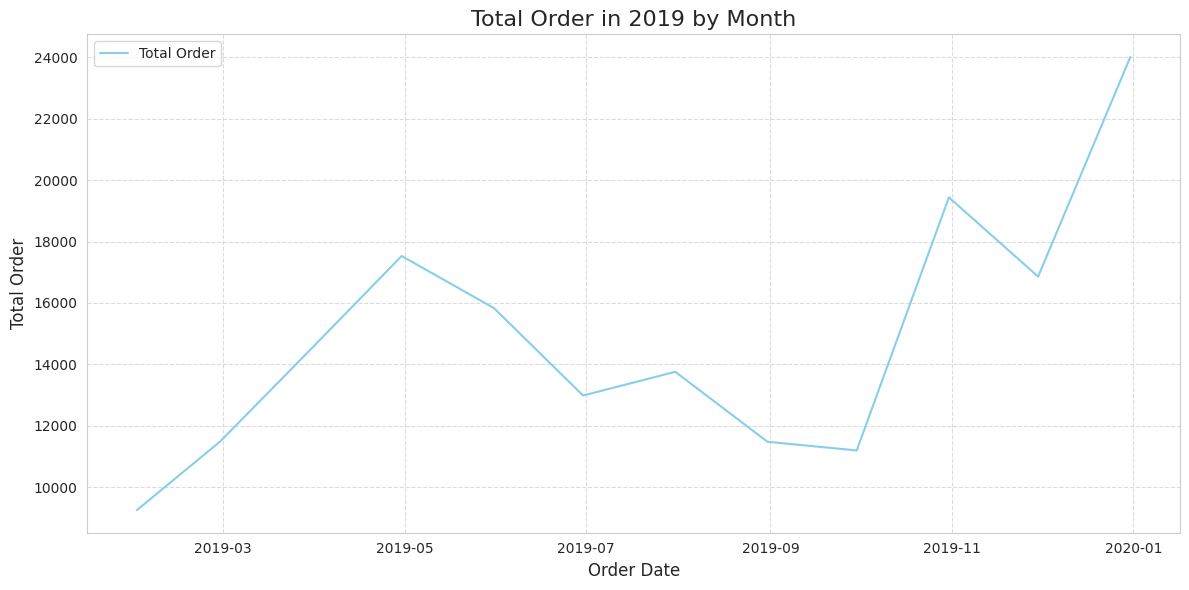

In [ ]:
# visz total order throughout 2019 in month
plt.figure(figsize=(12, 6))
plt.plot(sales_in_month.index, sales_in_month['Order ID'], label='Total Order', color='skyblue')

plt.title('Total Order in 2019 by Month', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Order', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Hasil ini menunukkan ada pola mungkin quartel atau mendekati quartel di mana ad pola kenaikan order, terus turun kembali dan naik lagi melonjak di akhir tahun. Ini mmungkin dibebabkan karena liburan, natal dsb yang membuat order meningkatkan

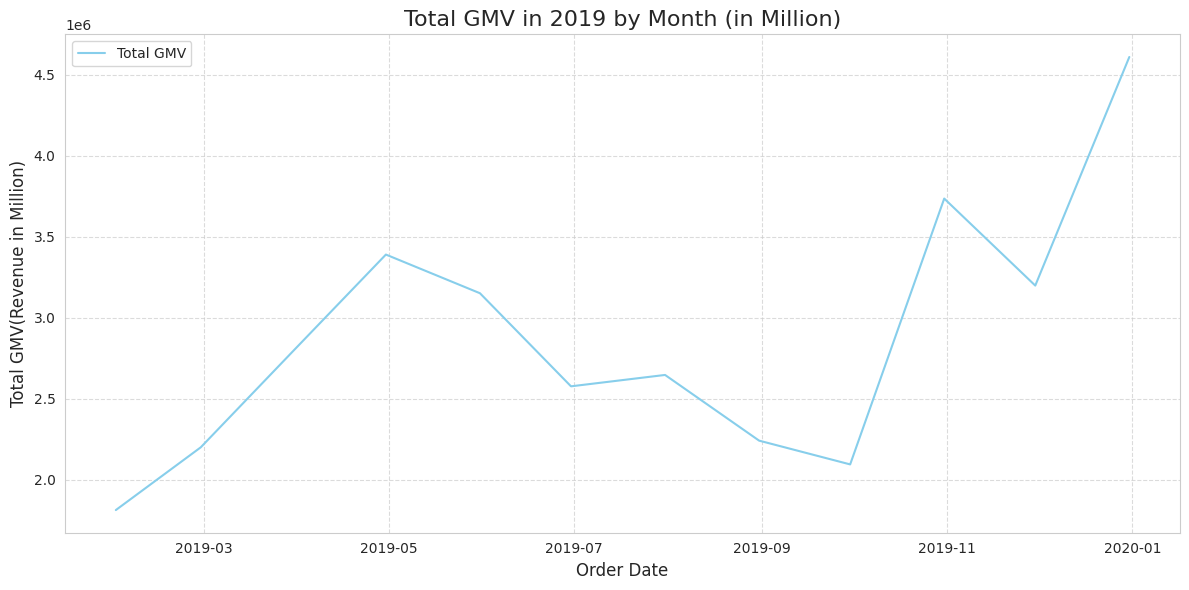

In [ ]:
# visz total GMV throughout 2019 in month
plt.figure(figsize=(12, 6))
plt.plot(sales_in_month.index, sales_in_month['Revenue'], label='Total GMV', color='skyblue')

plt.title('Total GMV in 2019 by Month (in Million)', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total GMV(Revenue in Million)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Demikian dengan GMV, secara pola tidak jauh berbeda dengan total order. Ini memandakan GMV memiliki korelasi atau pendorong gmv juga salah satunya dari jumlah order

### 2b. In Week

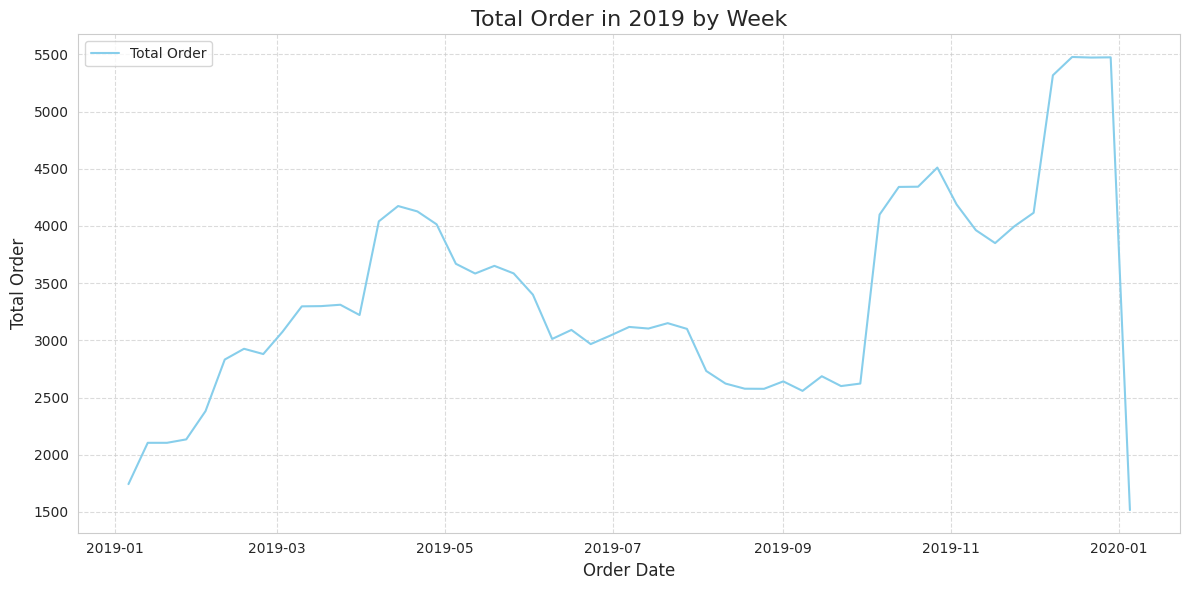

In [ ]:
# visz total order throughout 2019 in Week
plt.figure(figsize=(12, 6))
plt.plot(sales_in_week.index, sales_in_week['Order ID'], label='Total Order', color='skyblue')

plt.title('Total Order in 2019 by Week', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Order', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

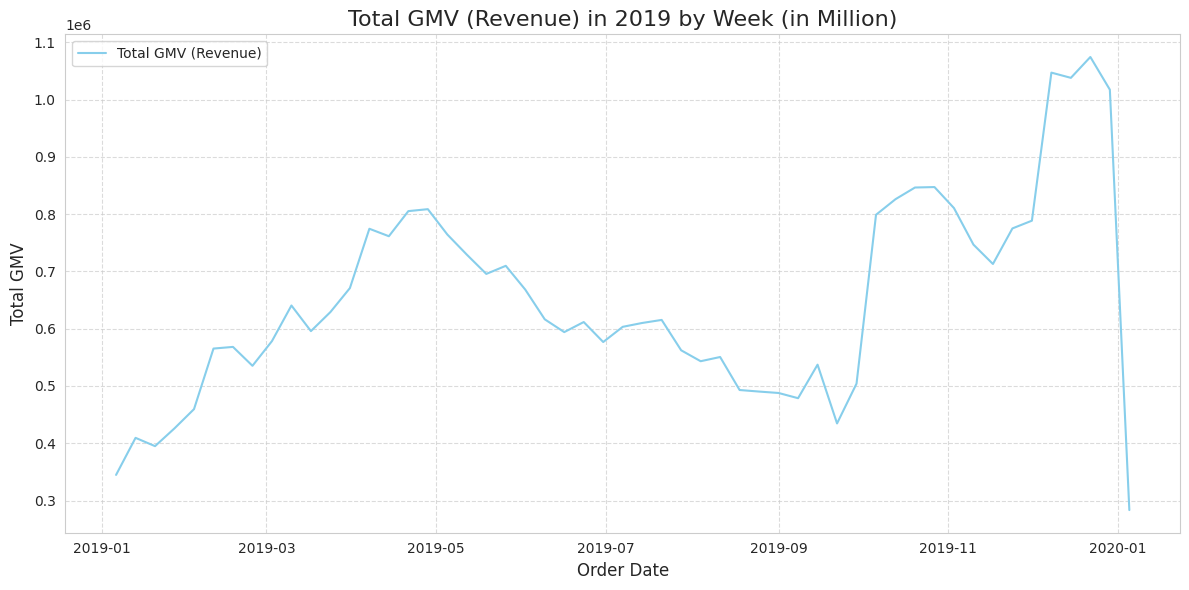

In [ ]:
# visz total order throughout 2019 in Week
plt.figure(figsize=(12, 6))
plt.plot(sales_in_week.index, sales_in_week['Revenue'], label='Total GMV (Revenue)', color='skyblue')

plt.title('Total GMV (Revenue) in 2019 by Week (in Million)', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total GMV', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Hasil week untuk order ataupun gmv memiliki pola yang juga mirip dengan month yang semakin menguatkan adanya pola. Hanya saja karena week, plot menjadi sedikit lebih kasar atau tidak mulus. Di plot juga ada data yang terbaca di tahun yang tidak utuh membuat seakan2 ada penuruna padahal record tidak penuh dalam tanggal atau label x line tersebut

### 2c. In Daily

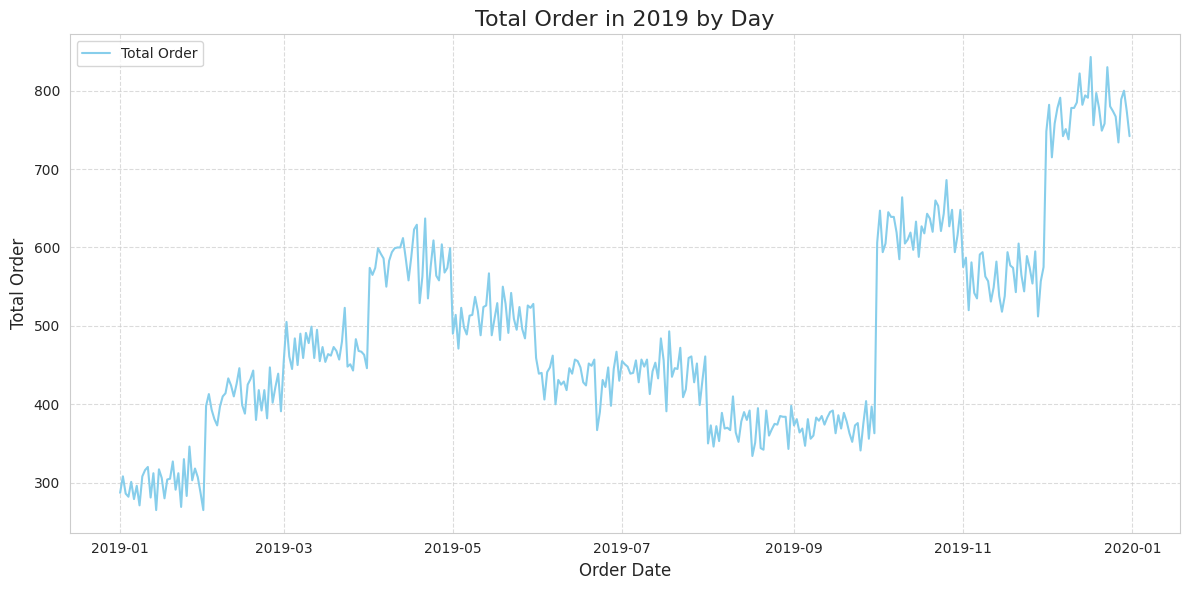

In [ ]:
# visz total order throughout 2019 in daily
plt.figure(figsize=(12, 6))
plt.plot(sales_in_day.index, sales_in_day['Order ID'], label='Total Order', color='skyblue')

plt.title('Total Order in 2019 by Day', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Order', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

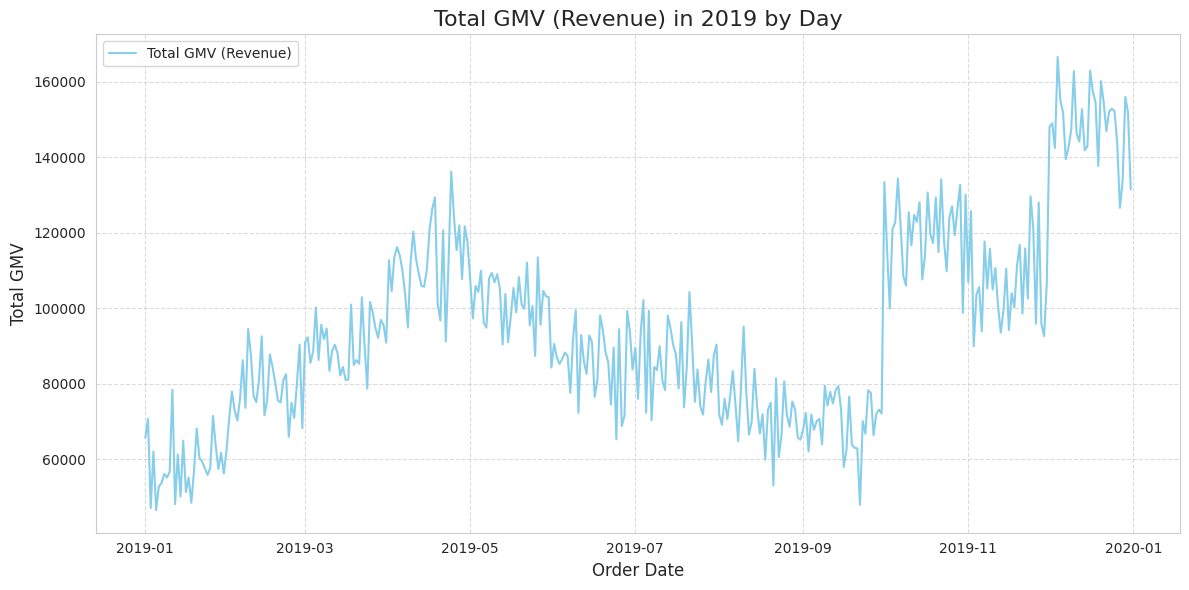

In [ ]:
# visz total order throughout 2019 in daily
plt.figure(figsize=(12, 6))
plt.plot(sales_in_day.index, sales_in_day['Revenue'], label='Total GMV (Revenue)', color='skyblue')

plt.title('Total GMV (Revenue) in 2019 by Day', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total GMV', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

pola juga tidak berbeda jauh dengan week atuapun montlhy, ada pola kenaikan di bulan 1-4 kemudian menurun dari 5 sampai 9 lanjut naik lagi sampai akhir bulan. Dan karena ini hari plot jadi semakin tidak mulus atau kurang smooth

## 3: Top 10 Produk yang berkontribusi terhadap revenue dalam 3 bulan terakhir

Soal produk yang paling sering dibeli sebenarnya bisa dalam dua pendekatan/point of view. Jika dilihat dari paling sering masuk ke dalam transaksi maka perhitunggan dengan `value_counts` bisa dilakukan.

Namun jika paling sering dibeli merujuk pada produk yang terjual dalam volume unit terbanyak makaa groupby berdasarkan produk lalu sum jumlah quantity order bisa dilakukan

In [ ]:
df_sales_cleaned['Product'].value_counts()

,count
Product,
USB-C Charging Cable,21855
Lightning Charging Cable,21605
AAA Batteries (4-pack),20609
AA Batteries (4-pack),20558
Wired Headphones,18848
Apple Airpods Headphones,15521
Bose SoundSport Headphones,13295
27in FHD Monitor,7495
iPhone,6838


dari point of view produk paling sering masuk dalam transaksi/order, produk USB charge paling sering. begitpun dengan top 3 lainnya juga berhbungan dengan accesoris

In [ ]:
df_sales_cleaned.groupby('Product')['Quantity Ordered'].sum().reset_index().sort_values(by='Quantity Ordered', ascending=False)

,Product,Quantity Ordered
5,AAA Batteries (4-pack),30981
4,AA Batteries (4-pack),27615
15,USB-C Charging Cable,23927
12,Lightning Charging Cable,23163
17,Wired Headphones,20520
6,Apple Airpods Headphones,15633
7,Bose SoundSport Headphones,13427
2,27in FHD Monitor,7538
18,iPhone,6845
1,27in 4K Gaming Monitor,6238


Sementara jiak dilihat dari point of view total unit palong banyak terjual sebagai produk paling sering dibeli, maka AAA Batteris adalah paling banyak dengan unit terjual sebanyak 30.981 unit

adapun jika ditarik dari soal berkontribusi terhadap revenue dalam 3 bulan terakhir maka dilakukan dengan menjumlah revenue

In [ ]:
# create var start date and end date (last 3 months)
start_date = '2019-10-01'
end_date = '2019-12-31'


# use filter with start_date and end_date
sales_last_3_months = df_sales_cleaned[
    (df_sales_cleaned['Order Date'] >= start_date) &
    (df_sales_cleaned['Order Date'] <= end_date)
]

# check the result
sales_last_3_months.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue
30206,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",1700.00
30207,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",600.00
30208,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",11.95
30209,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",149.99
30210,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",11.95


In [ ]:
# create filter top 10 product
column = ['Product']

grouping = {'Revenue': 'sum'}

top_10_product_last_3_months = sales_last_3_months.groupby(column).agg(grouping). \
    reset_index(). \
    sort_values(by=['Revenue'], ascending=False). \
    head(10)

top_10_product_last_3_months

,Product,Revenue
13,Macbook Pro Laptop,2708100.00
18,iPhone,1584800.00
14,ThinkPad Laptop,1345986.54
9,Google Phone,1071600.00
1,27in 4K Gaming Monitor,836528.55
6,Apple Airpods Headphones,780150.00
3,34in Ultrawide Monitor,778599.51
8,Flatscreen TV,486900.00
7,Bose SoundSport Headphones,448455.15
2,27in FHD Monitor,366875.54


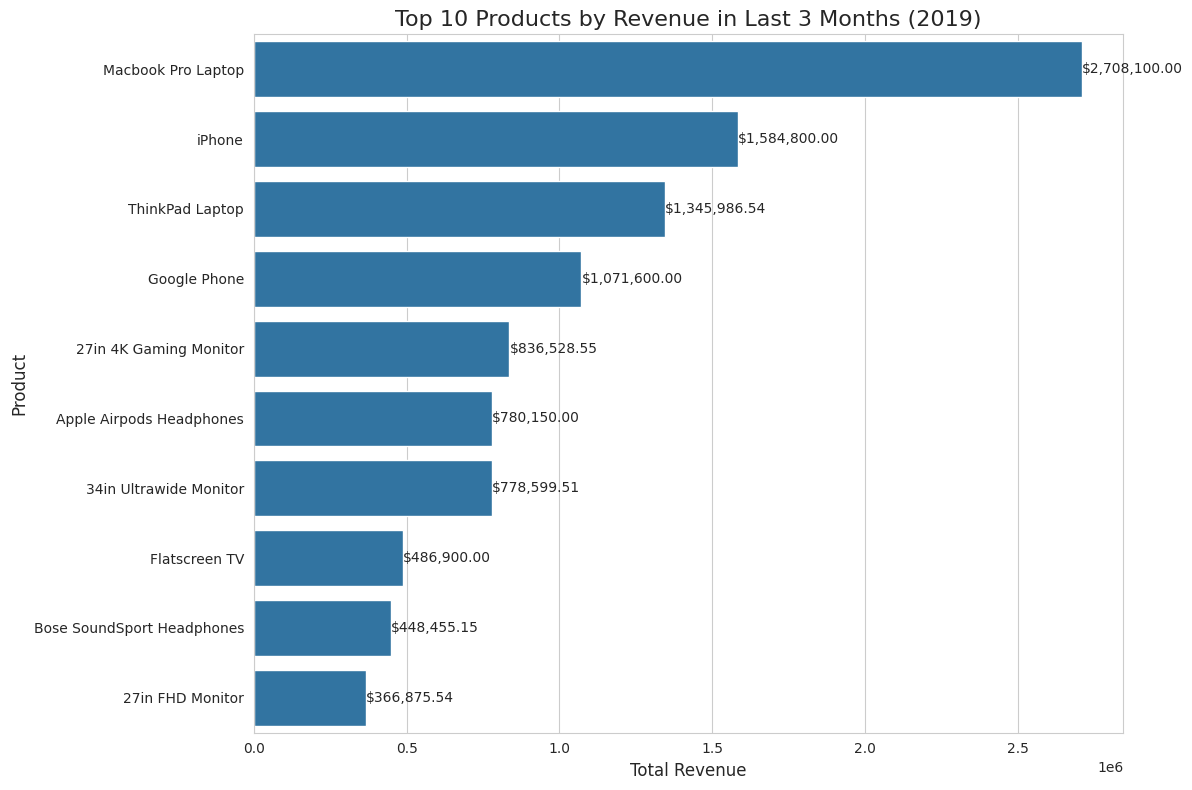

In [ ]:
# set styole
sns.set_style('whitegrid')

# create plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Revenue', y='Product', data=top_10_product_last_3_months)
plt.title('Top 10 Products by Revenue in Last 3 Months (2019)', fontsize=16)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Product', fontsize=12)

# Create label
for index, value in enumerate(top_10_product_last_3_months['Revenue']):
    plt.text(value, index, f'${value:,.2f}', va='center')

plt.tight_layout()

Dalam tiga bulan terakhir, produk yang berkontribusi besar terhadap revenue adalah Macbook Pro Laptop. Ini berarti produk ini disukai dalam 3 bulan terakhir dan produk ini juga termasuk kategori barang mahal atau harganya tidaklah murah.

Selain itu, hasil ini bisa didapatkan sebuah analisis untuk produk-produk yang dibundling
* Dalam garis besar, bundling produk elektronik dengan tambahan penawaran diskon, gratis pengiriman, dan sebagainya bisa dilakukan
* Untuk scope yang lebih terkhusus, kita bisa melakukan bundling dalam beberapa hal:
  * Bundling Smartphone & Accesoris: produk smartphone, seperti Iphone dan Google Phone dapat dibundling dengan accessoris, seperti Apple Airpods Headpones ataupun Bose SoundSport Heandpones.
  * Bundling Laptop dan Monitor/TV: Meskipun Laptop sudah memiliki layar, namun terkadang ada beberapa preferensi membeli monitor atau TV untuk dijadikan dual monitor atau untuk mendapatkan ukuran screen yang lebar. Maka dari itu, ini juga bisa dibundling

Langkah selanjutnya tim marketing bisa melakukan hipotesis testing untuk melihat apakah dalam satu order produk-produk yang direkomendasi bundling terbukti secara statistik bahwa mereka dibeli secara bersamaan dalam satu order.


## 4: Top 5 Kota dengan total order terbanyak dan 5 Kota yang memiliki rata-rata spending terbesar

In [ ]:
df_sales_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99


In [ ]:
# by pattern, city can be extracy by ','
df_sales_cleaned['City'] = df_sales_cleaned['Purchase Address'].str.split(',').str[1].str.strip()

# check the result
df_sales_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Revenue,City
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",23.90,Dallas
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",99.99,Boston
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",600.00,Los Angeles
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",11.99,Los Angeles
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",11.99,Los Angeles


In [ ]:
# create filter top 5 city with most order
top5_order_city = df_sales_cleaned.groupby('City')['Order ID'].nunique().reset_index()
top5_order_city.rename(columns={'Order ID': 'Total_Order'}, inplace=True)
top5_order_city.sort_values(by='Total_Order', ascending=False, inplace=True)
top5_order_city = top5_order_city.head(5)

# check the result
top5_order_city

,City,Total_Order
7,San Francisco,42887
4,Los Angeles,28497
5,New York City,23840
2,Boston,19088
0,Atlanta,14253


Alasan pengguanan `unique` masih sama bahwa **satu Order ID bisa mencakup beberapa baris produk atau untuk beberapa produk**. Maka dari itu, perhitungan menggunakan nunique() adalah cara yang paling akurat untuk menghitung jumlah pesanan yang berbeda.

In [ ]:
# create filter 5 total spending by city
top5_spending_city = df_sales_cleaned.groupby('City')['Revenue'].sum().reset_index()
top5_spending_city.rename(columns={'Revenue': 'Total_Revenue'}, inplace=True)
top5_spending_city = top5_spending_city.sort_values(by='Total_Revenue', ascending=False).head(5)

# check result
top5_spending_city

,City,Total_Revenue
7,San Francisco,8252258.67
4,Los Angeles,5447304.29
5,New York City,4660526.52
2,Boston,3657300.76
0,Atlanta,2794199.07


In [ ]:
# create filter 5 avg spenting by city
top5_avgspending_city = df_sales_cleaned.groupby('City')['Revenue'].mean().reset_index()
top5_avgspending_city.rename(columns={'Revenue': 'Avg_Revenue'}, inplace=True)
top5_avgspending_city = top5_avgspending_city.sort_values(by='Avg_Revenue', ascending=False).head(5)

# check result
top5_avgspending_city

,City,Avg_Revenue
0,Atlanta,187.996977
5,New York City,187.644503
3,Dallas,186.796824
8,Seattle,186.575315
6,Portland,186.324331


Berdasarkan kedua hasil ini menunjukkan bahwa tidak selama total order paling besar sejalan dengan rata-rata spendingnya juga. Hasil di atas menujukkan:
* Jika dihubungkan dengan total spending (Total_Revenue), 5 Kota dengan order terbanyak juga memiliki total spending terbesar juga, bahkan secara urutan tidak berubah. San Fransisco, Los Angeles, NY, Boston, dan Atlatan secara brerurutan menempati 5 kota teratas dengan total order dan total spending terbesar.
* Berbeda dengan rata-rata, nilai order terbesar tidak serta merta membuat rata-rata spending juga tertinggi. hal ini tentu dipengaruhi oleh outlier.
* Misalnya Kota San Frasisco dengan total order terbanyak sebesar 42.898 order terjadi, namun tidak masuk dalam 5 besar kota dengan rata-rata spending terbesar.
* Contih lainnnya adalah Atlant, meskipun dalam Top 5 Order kota ini paling rendah, Atlanta secara rata-rata spending paling besar, dimana mencapai ~187.99.

## 5: Rush Hour Penjualan paling aktif

In [ ]:
# extract time in hour
df_sales_cleaned['hour'] = df_sales_cleaned['Order Date'].dt.hour

# agregate order in hour (24 hour)
sales_by_hour = df_sales_cleaned.groupby('hour').agg(
    Total_Orders=('Order ID', 'nunique')).reset_index()

# check the result
sales_by_hour.head()

,hour,Total_Orders
0,0,3748
1,1,2246
2,2,1192
3,3,801
4,4,810


In [ ]:
# check unique in hour
sales_by_hour.hour.value_counts()


,count
hour,
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1


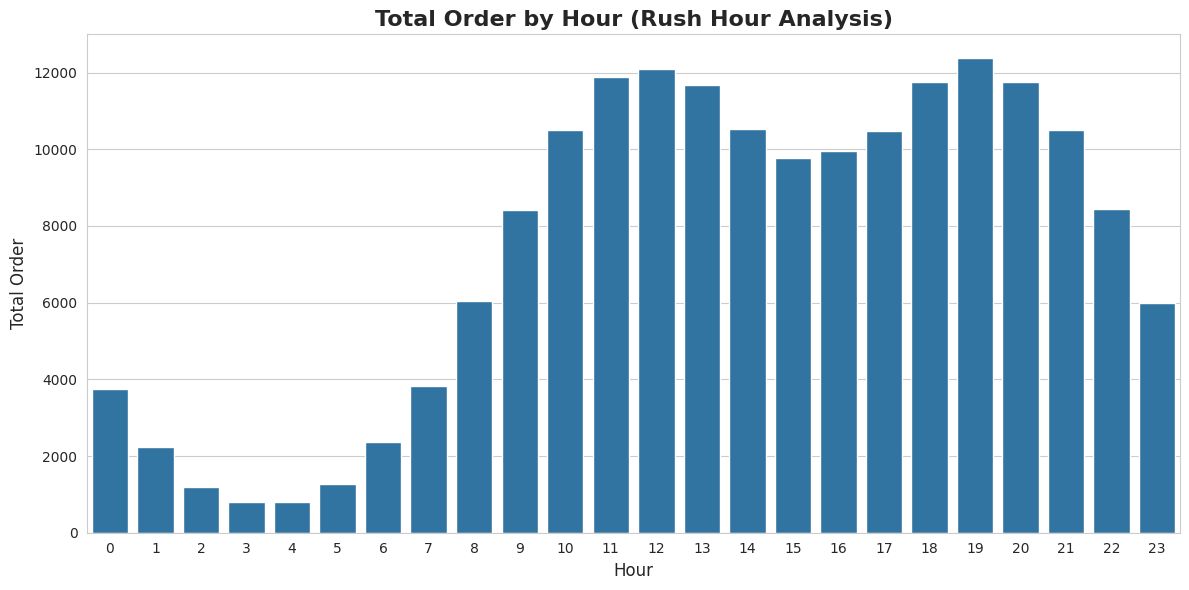

In [ ]:
# create visz
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Total_Orders',
            data=sales_by_hour
            )

plt.title('Total Order by Hour (Rush Hour Analysis)', fontsize=16, fontweight='bold')
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Total Order', fontsize=12)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Jumlah order paling tinggi terjadi di jam-jam istirahat atau menjelang siang sekitar 11-13. Kemudian turun kembali sampai sore menjelas malam. Tren memuncak lagi saat menuju jam 17-20.

Ini menandakan rush hour berada di sekitar jam 11-13 dan 17-20 yang mana ini sesuaikan dengan pola yang biasa kita temui disehari-hari, di sela2 orang istirahat akan membuat ecommerce dan mungkin berpotensi melakukan checkout atau belanja. Tentunya tim marketing perlu mempertimbangkan jam2 ini misalnya terkait promo atau notifikasi untuk mengecek barang yang sempat dilihat atau disukai oleh konsumen

# 6. Forecasting Total Order

Objective:
* Memprediksi jumlah transaksi untuk 1 bulan ke depan dengan data harian
* Menggunakan 2 model untuk melakukan forecasting (time series analysis)
* Membandingkan performa antara dua model untuk mencari MAPE terkecil.

Sebelum melakukan modelling, kita akan melihat lagi tren dari jumlah transaksi, melakukan decompose dari total transaksi sepanjang tahun 2019, melakukan stationary test, mengecek autokorelasi, dan baru dilanjutkan dengan modelling

## Time Series Visualisasi

In [ ]:
# calculate order in daily
order_daily = df_sales_cleaned.set_index('Order Date').resample('D').agg({
    'Order ID': 'nunique'
})

# check the result
order_daily.head()

,Order ID
Order Date,
2019-01-01,287
2019-01-02,308
2019-01-03,286
2019-01-04,282
2019-01-05,301


In [ ]:
order_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Order ID  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


Alasan pengguanan `unique` masih sama bahwa **satu Order ID bisa mencakup beberapa baris produk atau untuk beberapa produk**. Maka dari itu, perhitungan menggunakan nunique() adalah cara yang paling akurat untuk menghitung jumlah pesanan yang berbeda.

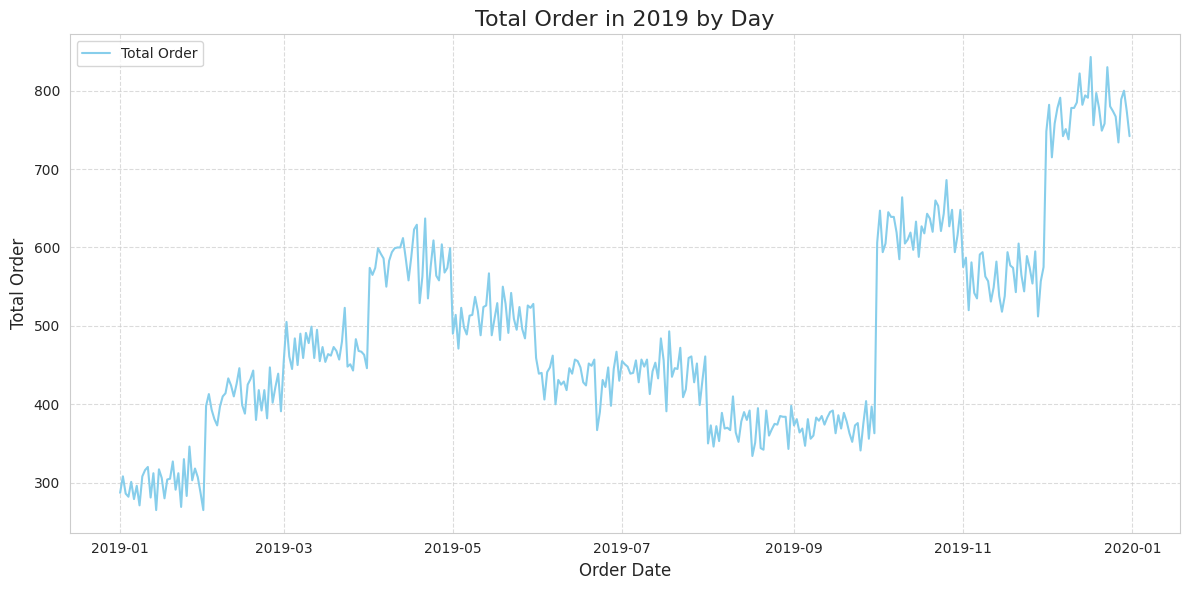

In [ ]:
# visz total order throughout 2019 in daily
plt.figure(figsize=(12, 6))
plt.plot(order_daily.index, order_daily['Order ID'], label='Total Order', color='skyblue')

plt.title('Total Order in 2019 by Day', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Order', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Hasil ini menunjukkan adanya tren dan seasonal yang terlihat dari pola. Seperti yang sudah disingguh di sebelum-sebelumya, bahwa adanya pola naik dari bulan ke-1 sampia bulan ke-4, kemudian turun sampai bulan ke-9/10 lanjut naik lagi sampai akhir tahun.

Untuk selanjutnya akan coba decomposition

## Decomposition

Dari pola sebenarnya amplitudonya (besaran) plot tidak terlihat terlalu konstan. Dengan kata lain, ada pola musiman yang memiliki fluktuasi dengan lebar yang lebih besesar. Jika dilihat sekilas, besarnya pola musiman fluktuasinya menjadi lebih besar menjelang akhir tahun.

Model `Multiplicative` mungkin akan cocok karena  tren penjualan cenderung meningkat di akhir tahun dan lonjakan harian tampak lebih besar. Namun untuk tahap awal saya coba pake pake `Additive` dulu.

### Model Additive

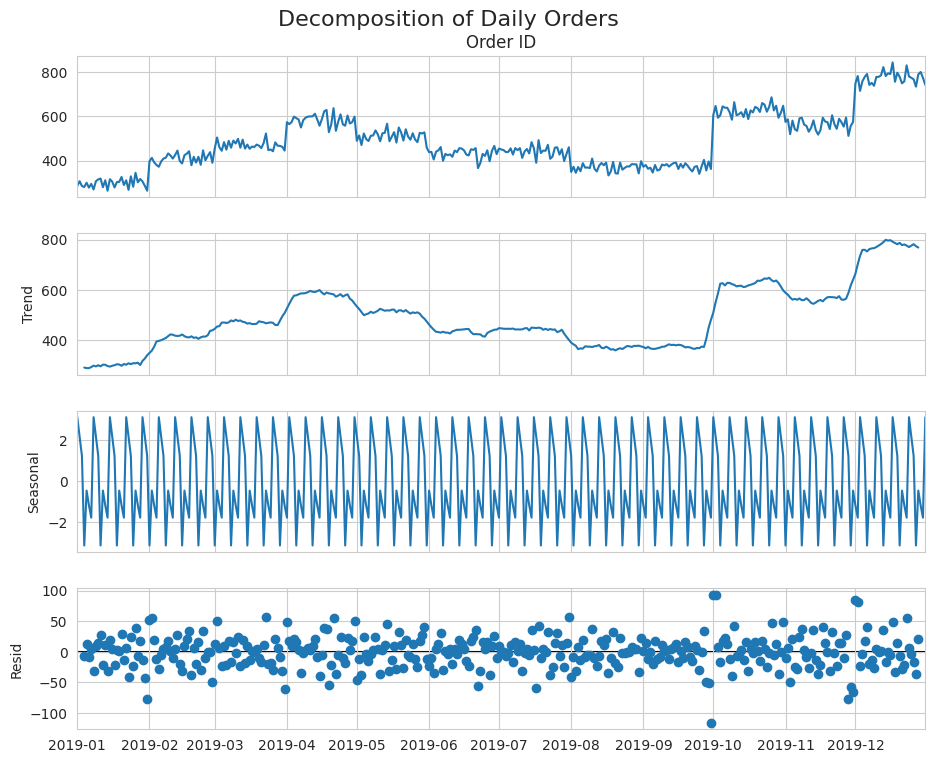

In [ ]:
# create decompisiton
decomposition = seasonal_decompose(order_daily['Order ID'], model='additive')

# plot decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Decomposition of Daily Orders', fontsize=16)
plt.show()

Dari data asli dan Trend sebenarnya bisa dikatakan adanya trend naik di awal, menurun di pertengahan, dan melonjak lagi di akhir tahun. Namun yang perlu diperhatikan residual plotnya yang terlihat tidak ideal. Plot yang dicari adalah fluktuasi di sekitar 0 namun beberapa titik menunjukkan adanya variansi yang berubah dalam deret waktu tertentu. Maka dari itu, kita akan **coba dengan model multiplicative**

### Model Multiplicative

In [ ]:
order_daily.head()

,Order ID
Order Date,
2019-01-01,287
2019-01-02,308
2019-01-03,286
2019-01-04,282
2019-01-05,301


In [ ]:
order_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
Order ID,365.0,488.783562,128.834227,265.0,391.0,457.0,575.0,843.0


Karena multplicative, maka perkalian atas data yang bernilai 0 sangat dihindari. Maka dari itu, kita perlu cek terlebih dahulu

In [ ]:
# check null value
zero_values = (order_daily['Order ID'] == 0).sum()

print(f"Jumlah hari dengan nol pesanan: {zero_values}")

Jumlah hari dengan nol pesanan: 0


Tidak ada nilai 0 dalam data. Maka tanpa Order ID (total order in daily) tidak perlu diadjusted denga nmengalikan konstanta yang kecil.

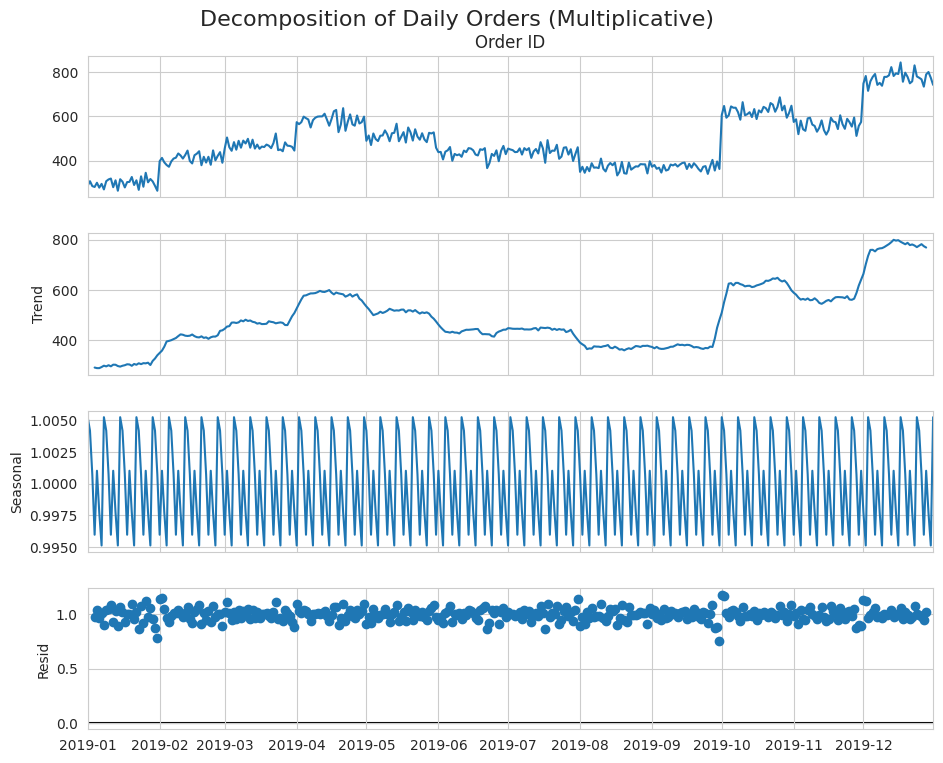

In [ ]:
# create decompose multiplicate
decomposition = seasonal_decompose(order_daily['Order ID'], model='multiplicative')

# Plot the decomposition result
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Decomposition of Daily Orders (Multiplicative)', fontsize=16)
plt.show()

Dari sini pola, trend, dan seasonal juga terlihat. Selain itu, hasil model fluktuative menunjukkan residual yang tidak mengubah apapun karena bernilai 1. Dalam multplicative (perkalian), residual yang ideal adalah 1 bukan 0. Artinya ini menunjukan bawah multiplicative lebih bagus karena pengurangaian, data-data time seriies menjadi komponen tren dan musiman, dan sisanya (residual) adalah faktor pengali yang rata-rata bernilai satu, yang berarti model sudah tepat.

Setelah mengetahui pola, trend, dan seasonal dalam data. kita perlu mengecek bagaimana stationarynya dan autocorrelation dari data.

## Stationary Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

# test stationary test
dftest = adfuller(order_daily['Order ID'])
pvalue = dftest[1]
print(f'P-value: {pvalue}')

if pvalue > 0.05:
    print('Data non-stationary')
else:
    print('Data stationary')

P-value: 0.7025177855652346
Data non-stationary


Jika menggunakan model arima atau sarima, differencing secara manual untuk mendapat data stationary tidak usah dilakukan karena model ini memiliki parameter d untuk menangani hal tersebut. Walaupun differencing juga tidak terlalu diperlukan jika menggunakan model machine learning seperti random forest, namun kita perlu membuat fitur-fitur baru (feature engineering) yang dapat menangkap tren dan musiman agar model dapat memahaminya.

## Test ACF dan PACF

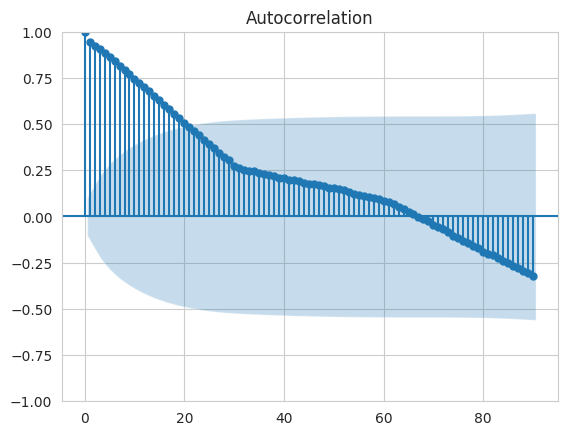

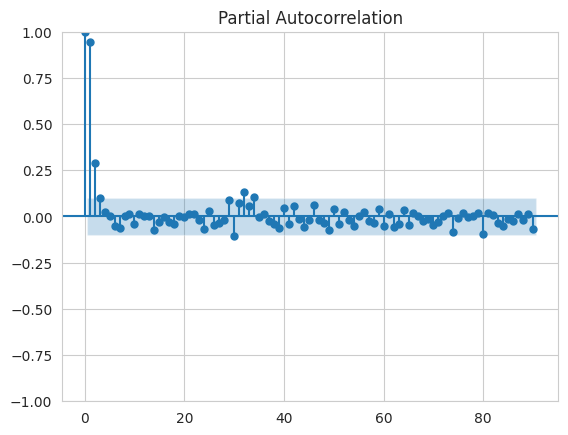

In [ ]:
# Plot ACF
plot_acf(order_daily['Order ID'], lags=90)
plt.show()

# Plot PACF
plot_pacf(order_daily['Order ID'], lags=90)
plt.show()

lags = 90 ini untuk melihat interval yang lebih luas, selain berdasarkan pengamatan yang membuat hipotesis ada pola naik turun dalam kuartalan. Walaupun lags = 90 atau 30 sama2 valid karenan ini mengungakpan bagaimana parameter ktia diinput nanti saat memodelkan arima

* Plot ACF menunjukkan penurunan yang sangat lambat. Batang-batang tetap berada di luar area biru (interval kepercayaan) untuk waktu yang lama. Ini adalah konfirmasi visual yang jelas bahwa data Anda tidak stationary dan memiliki tren yang kuat.
* Plot PACF juga menunjukkan korelasi yang signifikan pada lag=1, yang kemudian menurun dengan cepat. Ini adalah indikasi bahwa ada korelasi yang kuat dengan data satu hari sebelumnya.

Ini mencari catatan jika ingin melakukan model lebih baik menggunakan SARIMA karena dapat mengangai secara eksplisit pola musiman. Langkah selanjutnya, saya coba melakukan differencing

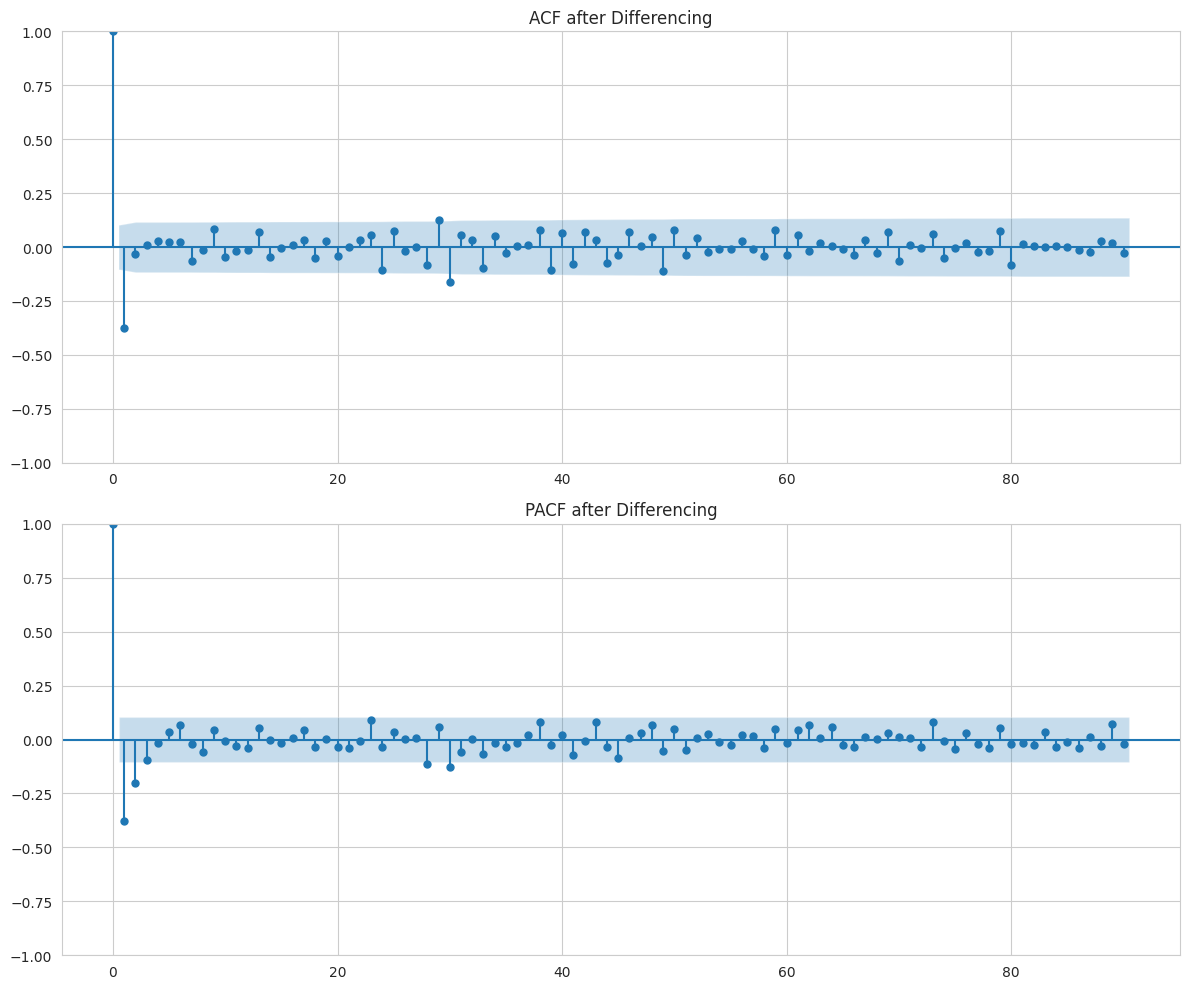

In [ ]:
# differency data
order_daily_diff1 = order_daily['Order ID'].diff().dropna()

# create plot ACF dan PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF
plot_acf(order_daily_diff1, lags=90, ax=axes[0])
axes[0].set_title('ACF after Differencing')

# Plot PACF
plot_pacf(order_daily_diff1, lags=90, ax=axes[1])
axes[1].set_title('PACF after Differencing')

plt.tight_layout()
plt.show()

* Differencing akan menghilangkan tren ddan musiman. Plot ini juga yang akan menentukan parameter p dan q untuk model SARIMA jiak dipilih sebagai pemodelan.
* Plot ACF dan PACF setelah differencing kini menunjukkan korelasi yang menurun dengan cepat, menandakan data sudah stationary.
* Dari plot tersebut, parameter p dan q yang mungkin untuk model SARIMA, jikaa dipilih, kemungkinan adalah 1, karena adanya lonjakan signifikan di lag=1 pada masing-masing plot.Untuk lebih lanjut, akan coba dieksplorasi sebelum melakukan model

## Data Preparation

### Feature Engineering

 Seperti yang disebutkan sebelumnya, bahwa salah satu model yang akan dilakukan adalah model machine learning. Untuk itu, perlu dilakukan feature enginering untuk menangkap pola lebih lanjut ada model bisa belajar.

 Pada tahap ini akan dilakukan ekstrak tanggal lebnih jauh.

In [ ]:
# Ekstraksi fitur waktu & kalender
def create_time_features_daily_order(df_input):
    df_output = df_input.copy()
    df_output['year'] = df_output.index.year
    df_output['month'] = df_output.index.month
    df_output['day'] = df_output.index.day # day of month
    df_output['dayofweek'] = df_output.index.dayofweek
    df_output['dayofyear'] = df_output.index.dayofyear
    df_output['weekofyear'] = df_output.index.isocalendar().week.astype(int)
    df_output['quarter'] = df_output.index.quarter
    df_output['is_weekend'] = (df_output.index.dayofweek >= 5).astype(int) # Sabtu=5, Minggu=6

    # Fitur siklik untuk seasonal
    df_output['dayofweek_sin'] = np.sin(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofweek_cos'] = np.cos(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofyear_sin'] = np.sin(2 * np.pi * df_output['dayofyear']/365)
    df_output['dayofyear_cos'] = np.cos(2 * np.pi * df_output['dayofyear']/365)
    df_output['month_sin'] = np.sin(2 * np.pi * df_output['month']/12)
    df_output['month_cos'] = np.cos(2 * np.pi * df_output['month']/12)
    return df_output

df_features = create_time_features_daily_order(order_daily)

selanjutnya akan mengekstrak lag da nrolling  dari Order ID (total order)

In [ ]:
def create_lag_rolling_features_order(df_input):
    df_temp = df_input.copy()
    target_col = 'Order ID'

    # Lag features dari target
    df_temp[f'{target_col}_lag_1'] = df_temp[target_col].shift(1) # Kemarin
    df_temp[f'{target_col}_lag_7'] = df_temp[target_col].shift(7) # Seminggu lalu (seasonal mingguan)
    df_temp[f'{target_col}_lag_365'] = df_temp[target_col].shift(365) # Setahun lalu (seasonal tahunan)

    # Rolling window features dari target
    df_temp[f'{target_col}_rolling_mean_7'] = df_temp[target_col].rolling(window=7, min_periods=1).mean()
    df_temp[f'{target_col}_rolling_std_7'] = df_temp[target_col].rolling(window=7, min_periods=1).std()
    df_temp[f'{target_col}_rolling_mean_30'] = df_temp[target_col].rolling(window=30, min_periods=1).mean()

    return df_temp

df_features = create_lag_rolling_features_order(df_features)


# Handling missing values dari Fitur with mean in col
for col in df_features.columns:
    if df_features[col].isnull().any():
        df_features[col].fillna(df_features[col].mean(), inplace=True)

print(f"Ukuran data setelah feature engineering: {df_features.shape[0]} baris")

Ukuran data setelah feature engineering: 365 baris


### Split Data

In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Freq: D
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order ID                  365 non-null    int64  
 1   year                      365 non-null    int32  
 2   month                     365 non-null    int32  
 3   day                       365 non-null    int32  
 4   dayofweek                 365 non-null    int32  
 5   dayofyear                 365 non-null    int32  
 6   weekofyear                365 non-null    int64  
 7   quarter                   365 non-null    int32  
 8   is_weekend                365 non-null    int64  
 9   dayofweek_sin             365 non-null    float64
 10  dayofweek_cos             365 non-null    float64
 11  dayofyear_sin             365 non-null    float64
 12  dayofyear_cos             365 non-null    float64
 13  month_sin                 365 non-null

In [ ]:
# # Split data training, validasi, & testing menggunakan rasio
# train_ratio = 0.6
# val_ratio = 0.2
# test_ratio = 0.2

# total_days = len(df_features)
# train_size = int(total_days * train_ratio)
# val_size = int(total_days * val_ratio)
# test_size = total_days - train_size - val_size

# # Tentukan tanggal split berdasarkan jumlah hari
# split_date_val = df_features.index[train_size - 1]
# split_date_test = df_features.index[train_size + val_size - 1]

# # target col
# target_col = 'Order ID'

# # define feature
# ml_features = [col for col in df_features.columns if col not in [target_col]]

# # split train, valid, test
# X_train_ml = df_features.iloc[:train_size][ml_features]
# y_train_ml = df_features.iloc[:train_size][target_col]

# X_val_ml = df_features.iloc[train_size:train_size + val_size][ml_features]
# y_val_ml = df_features.iloc[train_size:train_size + val_size][target_col]

# X_test_ml = df_features.iloc[train_size + val_size:][ml_features]
# y_test_ml = df_features.iloc[train_size + val_size:][target_col]

# # split for clasic model
# y_train_ts = order_daily[target_col].iloc[:train_size]
# y_val_ts = order_daily[target_col].iloc[train_size:train_size + val_size]
# y_test_ts = order_daily[target_col].iloc[train_size + val_size:]

# # extract external features/ exogonuous for sarimax (non-target, non-lag/rolling)
# exog_cols_ts = features = [
#     'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
#     'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos'
# ]

# # apply the filter
# exog_cols_ts_filtered = [col for col in exog_cols_ts if col in df_features.columns]

# # split dataset for classic model
# exog_train_ts = df_features[exog_cols_ts_filtered].iloc[:train_size]
# exog_val_ts = df_features[exog_cols_ts_filtered].iloc[train_size:train_size + val_size]
# exog_test_ts = df_features[exog_cols_ts_filtered].iloc[train_size + val_size:]


# # check the shape
# print(f"Ukuran Data Training ML: {len(X_train_ml)} hari")
# print(f"Ukuran Data Validation ML: {len(X_val_ml)} hari")
# print(f"Ukuran Data Testing ML: {len(X_test_ml)} hari")
# print(f"Ukuran Data Training TS: {len(y_train_ts)} hari")
# print(f"Ukuran Data Validation TS: {len(y_val_ts)} hari")
# print(f"Ukuran Data Testing TS: {len(y_test_ts)} hari")

pada objektif, kita diminta untuk memprediksi 30 hari depan. sehingga split akan di define test valid berdasarkan ini

In [ ]:
# Tentukan horizon prediksi dalam jumlah hari
prediction_horizon_days = 30

# Tentukan ukuran set validasi dan pengujian dalam hari
val_size = prediction_horizon_days
test_size = prediction_horizon_days

# Tentukan ukuran set pelatihan
total_days = len(df_features)
train_size = total_days - val_size - test_size

# Tentukan tanggal split
# Pastikan indeks tidak terpotong
split_date_val = df_features.index[train_size - 1]
split_date_test = df_features.index[train_size + val_size - 1]

# target col
target_col = 'Order ID'

# define feature
ml_features = [col for col in df_features.columns if col not in [target_col]]

# split train, valid, test untuk ML model
X_train_ml = df_features.iloc[:train_size][ml_features]
y_train_ml = df_features.iloc[:train_size][target_col]

X_val_ml = df_features.iloc[train_size:train_size + val_size][ml_features]
y_val_ml = df_features.iloc[train_size:train_size + val_size][target_col]

X_test_ml = df_features.iloc[train_size + val_size:][ml_features]
y_test_ml = df_features.iloc[train_size + val_size:][target_col]

# split untuk classic model
y_train_ts = order_daily[target_col].iloc[:train_size]
y_val_ts = order_daily[target_col].iloc[train_size:train_size + val_size]
y_test_ts = order_daily[target_col].iloc[train_size + val_size:]

# extract external features/ exogonuous for sarimax (non-target, non-lag/rolling)
exog_cols_ts = [
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos'
]

# apply the filter
exog_cols_ts_filtered = [col for col in exog_cols_ts if col in df_features.columns]

# split dataset for classic model
exog_train_ts = df_features[exog_cols_ts_filtered].iloc[:train_size]
exog_val_ts = df_features[exog_cols_ts_filtered].iloc[train_size:train_size + val_size]
exog_test_ts = df_features[exog_cols_ts_filtered].iloc[train_size + val_size:]

# check the shape
print(f"Ukuran Data Training ML: {len(X_train_ml)} hari")
print(f"Ukuran Data Validation ML: {len(X_val_ml)} hari")
print(f"Ukuran Data Testing ML: {len(X_test_ml)} hari")
print(f"Ukuran Data Training TS: {len(y_train_ts)} hari")
print(f"Ukuran Data Validation TS: {len(y_val_ts)} hari")
print(f"Ukuran Data Testing TS: {len(y_test_ts)} hari")

Ukuran Data Training ML: 305 hari
Ukuran Data Validation ML: 30 hari
Ukuran Data Testing ML: 30 hari
Ukuran Data Training TS: 305 hari
Ukuran Data Validation TS: 30 hari
Ukuran Data Testing TS: 30 hari


## Modelling

In [ ]:
# Fungsi untuk evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    y_pred = np.maximum(0, y_pred) # order tidak bisa negatif
    # Menghitung Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Menghitung Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    # Menghitung Mean Absolute Percentage Error (MAPE)
    # Menghindari pembagian dengan nol jika ada nilai aktual 0
    y_true_cleaned = y_true.copy()
    y_true_cleaned[y_true_cleaned == 0] = 1e-9 # Ganti 0 dengan small number untuk menghindari pembagian angka 0

    mape = np.mean(np.abs((y_true - y_pred) / y_true_cleaned)) * 100
    print(f"{model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return rmse, mae, mape

# Fungsi untuk visualisasi perbandingan forecast vs aktual
def plot_predictions(y_train, y_val, y_test, y_pred_val, y_pred_test, model_name):
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Data Historis (Train)', color='blue', alpha=0.7)

    if y_val is not None:
      plt.plot(y_val.index, y_val, label='Data Validasi (Aktual)', color='black', linewidth=2)
      if y_pred_val is not None:
        y_pred_val_series = pd.Series(y_pred_val, index=y_val.index)
        plt.plot(y_val.index, y_pred_val_series, label=f'Prediksi {model_name} (Validasi)', linestyle='--', color='red')


    if y_test is not None:
      plt.plot(y_test.index, y_test, label='Data Testing (Aktual)', color='green', linewidth=2)
      if y_pred_test is not None:
        y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
        plt.plot(y_test.index, y_pred_test_series, label=f'Prediksi {model_name} (Testing)', linestyle='--', color='orange')


    plt.title(f'Prediksi {model_name} vs. Aktual', fontsize=16)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Total Order (Pesanan)', fontsize=12)

    plt.axvline(x=y_train.index.max(), color='grey', linestyle=':', label='Akhir Data Historis')

    if y_val is not None and len(y_val) > 0:
      plt.axvline(x=y_val.index.max(), color='gray', linestyle='--', label='Akhir Data Validasi')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### SARIMA

In [ ]:
len(y_val_ts)

30

In [ ]:
# # Pemodelan
# sarimax_model = ARIMA(y_train_ts,
#                       exog=exog_train_ts,
#                       order=(0, 0, 1),
#                       seasonal_order=(1, 1, 1, 30)).fit()

# y_pred_sarimax_val = sarimax_model.forecast(steps=len(y_val_ts), exog=exog_val_ts)

# rmse_sarimax_val, mae_sarimax_val, mape_sarimax_val = evaluate_model(y_val_ts, y_pred_sarimax_val, "SARIMA (0,0,1)(1,1,1,30) (Validation)")

# plot_predictions(y_train_ts, y_val_ts, None, y_pred_sarimax_val, None, "SARIMA (0,0,1)(1,1,1,30)")

Ada beberapa komponenn yang saya sesuaikan melihat hasil stationary, ACF dan PACF

non seasonal componen
* AR(1): PACF menunjukkan spike signifikan di lag 1 kemudian decay gradually
* d=1: Data memiliki trend non-stationary yang memerlukan satu kali differencing
* MA(1): ACF menunjukkan cut-off yang jelas setelah lag 1 dengan spike negatif signifikan

seasonal componen:
* SAR(1): Terdapat pola berulang di kelipatan lag 7 pada PACF meski tidak terlalu kuat
* D=1: Seasonal differencing untuk menghilangkan pola musiman yang tersisa
* SMA(1): Untuk menangkap error seasonal yang mungkin ada
* s=7: Data harian dengan pola mingguan (weekday vs weekend pattern)

SARIMA (1,1,1)(1,1,1,7) (Validation)
RMSE: 75.8701
MAE: 64.4866
MAPE: 11.41%


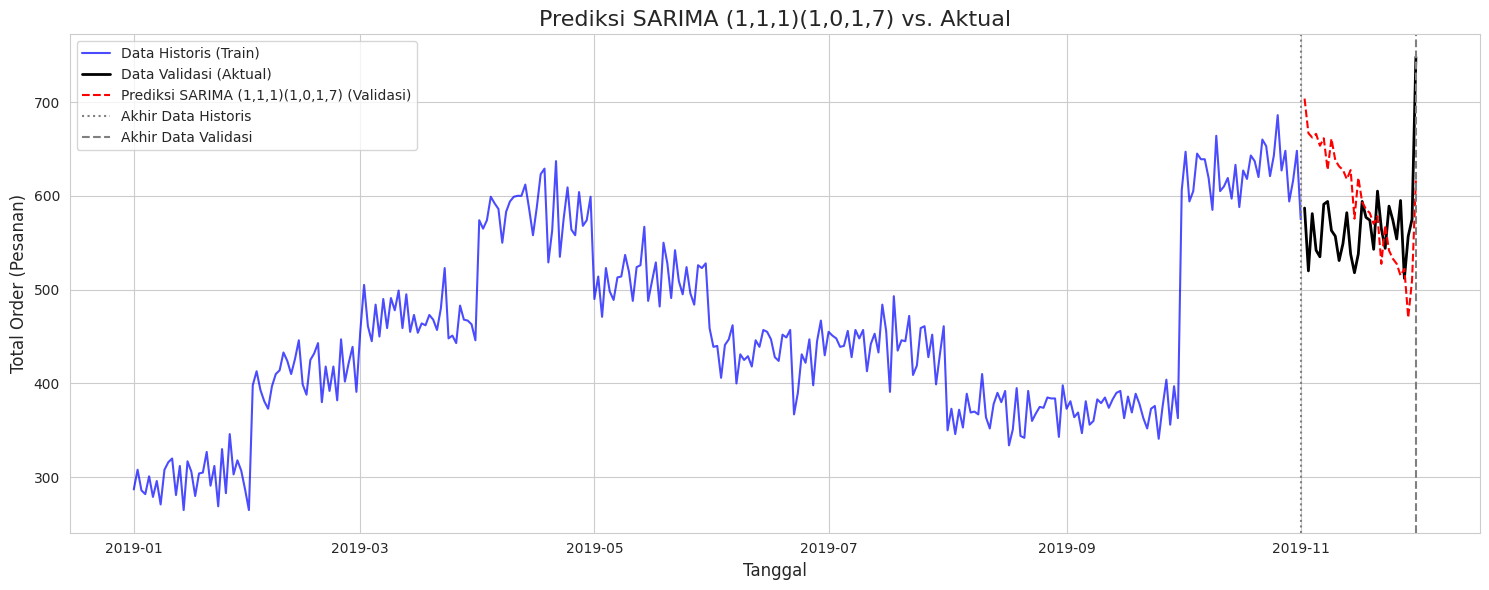

In [ ]:
sarimax_model = ARIMA(y_train_ts,
                      exog=exog_train_ts,
                      order=(1, 1, 1),           # Non-musiman: p=1, d=1, q=1
                      seasonal_order=(1, 1, 1, 7)).fit()  # Musiman: P=1, D=1, Q=1, m=7

y_pred_sarimax_val = sarimax_model.forecast(steps=len(y_val_ts), exog=exog_val_ts)

rmse_sarimax_val, mae_sarimax_val, mape_sarimax_val = evaluate_model(y_val_ts, y_pred_sarimax_val, "SARIMA (1,1,1)(1,1,1,7) (Validation)")

plot_predictions(y_train_ts, y_val_ts, None, y_pred_sarimax_val, None, "SARIMA (1,1,1)(1,1,1,7)")

Hasil MAPE menunjukkan MAPE sebesar 11.41% yang mana berarti ada error dalam prediksi model mencapai 11%. Tentunya inputan parameter perlu diesklporais lebih lanjut baik dalam visualiasi plot atuapun menggunakan tuning dengan beberapa input yang paling menghasilkan error terkecil

### Random Forest

Random Forest Regressor (Validation)
RMSE: 47.3786
MAE: 37.7130
MAPE: 6.60%


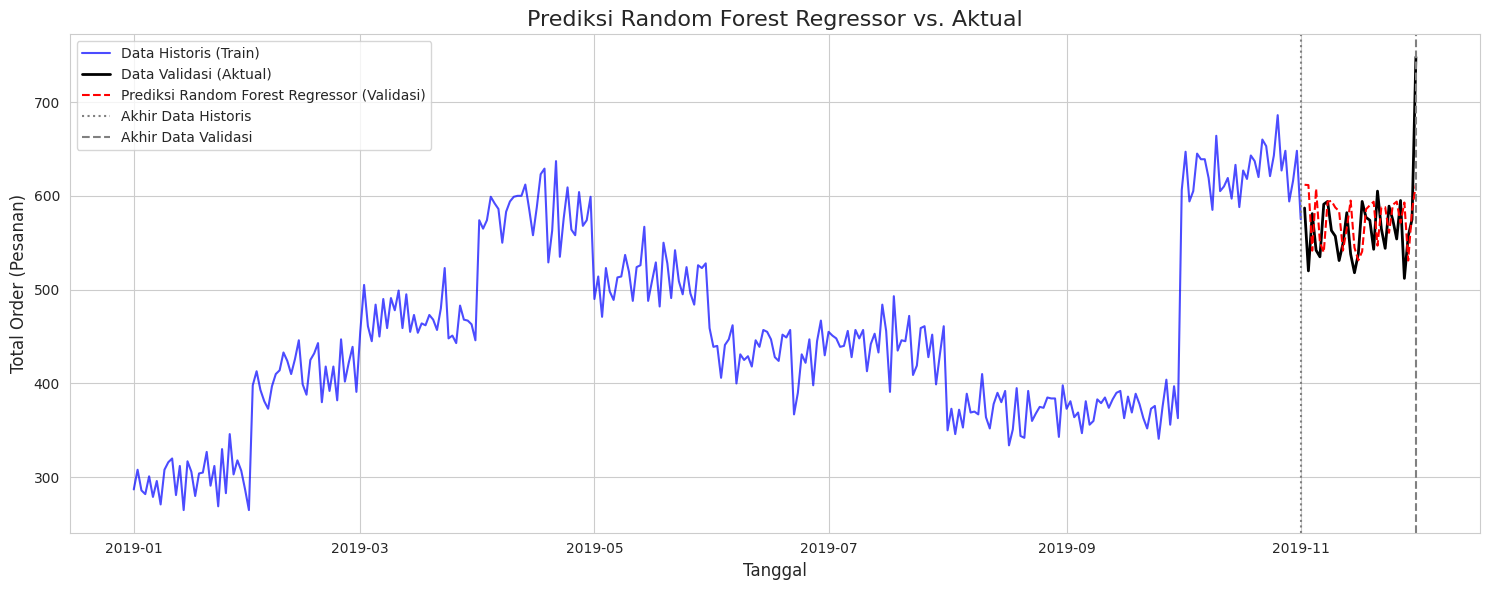

In [ ]:
# Pemodelan
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_ml, y_train_ml)

y_pred_rf_val = rf_model.predict(X_val_ml)

rmse_rf_val, mae_rf_val, mape_rf_val = evaluate_model(y_val_ml, y_pred_rf_val, "Random Forest Regressor (Validation)")
plot_predictions(y_train_ml, y_val_ml, None, y_pred_rf_val, None, "Random Forest Regressor")

Model Random Forest memiliki hasil MAPE yang lebih kecil yang berarti model ini lebih baik. Di mana MAPE 6,60%, terdapat 6% error pada model.

Hasil ini model ini juga akan diputuskan model ini akan dipilih untuk uji lagi ke set test.

## Model Evaluation

re-train dan evaluation

Random Forest Regressor (Test)
RMSE: 129.5740
MAE: 126.3257
MAPE: 16.19%


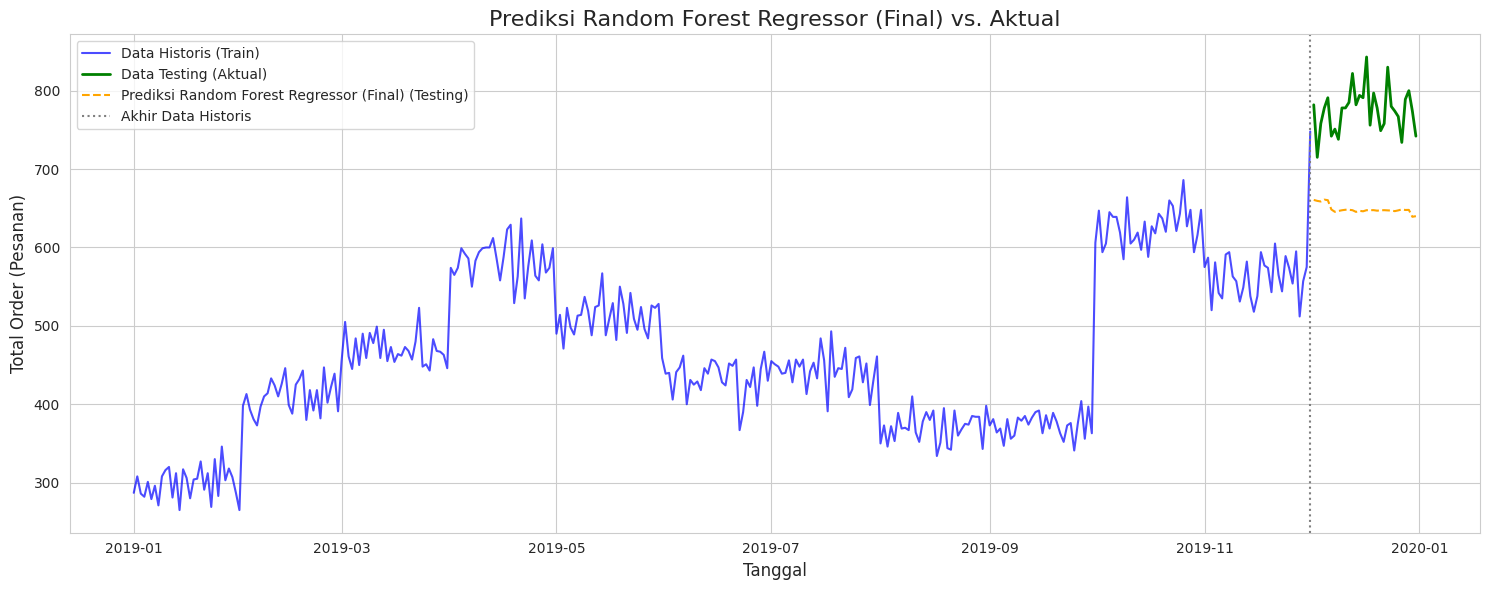

In [ ]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

X_train_val_ml = pd.concat([X_train_ml, X_val_ml])
y_train_val_ml = pd.concat([y_train_ml, y_val_ml])

best_model.fit(X_train_val_ml, y_train_val_ml)

y_pred_test_best_model = best_model.predict(X_test_ml)

rmse_test_best, mae_test_best, mape_test_best = evaluate_model(y_test_ml, y_pred_test_best_model, "Random Forest Regressor (Test)")

plot_predictions(y_train_val_ml, None, y_test_ml, None, y_pred_test_best_model, "Random Forest Regressor (Final)")

Hasil model menunjukkan masih overfitting karean MAPE lebih besar 16,19% dibandingkan sebelumnya yang hanya sekitar 6%. hal bisa (mungkin) jiga dikarenakan model kurang bisa menangkap data baru atau adanya lonjakan trend di akhir tahun.

Tentuunya hasil ini menjadi catatan untuk model ke depan bisa mengeskplor feaute engineering (menangkap pola liburan, diskon akhir tahun, dsb), mencoba model lain, atau melakukan tuning.